# Скоринг клиентов
## Автор: *Свириденко Дмитрий*
https://t.me/DmitrySvM


---



## Установка дополнительных библиотек

In [ ]:
# Библиотека 7zip
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
!pip install tensorflow

## Подключение библиотек, вспомогательные функции


In [ ]:
import datetime
import os
import subprocess
import shutil
import sys
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

from IPython.display import clear_output
# Установка параметров отображения
pd.set_option('display.max_columns', None)  # Показать все столбцы без сокращения
pd.set_option('display.width', 1000)        # Увеличить ширину вывода

# Асинхронная работа и работа с огромными файлами
import dask.dataframe as dd

# Отрисовка графиков
import matplotlib.pyplot as plt
# Отрисовка графики в ячейке colab
%matplotlib inline
# Назначение размера, стиля графиков и других параметров отрисовки по-умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (15, 5)

# Для работы  zip-архивами
import zipfile

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

#
from google.colab.data_table import DataTable
DataTable.max_columns = 100
DataTable.max_rows=30000

In [ ]:
from google.colab import files
from google.colab import drive
import gdown

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
import missingno as msno

from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
import tensorflow as tf

import seaborn as sns # Будем визулизировать данные этой библиотекой

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Concatenate

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, MaxPooling1D, Conv1D, Flatten, Dropout, BatchNormalization, Input, Embedding, SpatialDropout1D, concatenate, Concatenate, Activation
from keras.optimizers import Adam, Adadelta, SGD
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras import datasets, layers, models, losses
from keras.utils import load_img, to_categorical, plot_model
from sklearn.model_selection import train_test_split

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer

pd.set_option("display.max_columns", 100)
sns.set_style('darkgrid')

In [ ]:
import re
from tabulate import tabulate

In [ ]:
def reset_and_fix_random_at(seed_value):
    # Seed value
    # Apparently you may use different seed values at each stage
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)
    # for later versions:
    # tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    # for later versions:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
def ifelse(true_val, false_val):
  return true_val if true_val else false_val

In [ ]:
from itertools import product # Эта штука умеет перебирать значения

# функция перебора всех указанных значений указанных параметров для `func`
def call_all_compinations(func, verbose = 0, start_from = 1, seed=42, **params):
  """
  Вызывает функцию `func` со всеми возможными комбинациями параметров, указанных в словаре `params`.
  Возвращает список результатов вызова `func` для каждой комбинации.

  Parameters:
  -----------
  func : callable
      Функция, которую нужно вызвать с разными параметрами.
  verbose : int, optional (default=0)
      Уровень логирования.
  **params : dict
      Словарь параметров и их допустимых значений, для которых нужно вызвать функцию.

  Returns:
  --------
  results : list
      Список результатов вызова `func` для каждой комбинации параметров.

  Example:
  --------
  >>> def my_function(verbose, param1, param2):
  ...     print(f"param1 = {param1}, param2 = {param2}")
  ...     return param1 + param2
  ...
  >>> params = {"param1": [1, 2], "param2": [3, 4]}
  >>> call_all_combinations(my_function, verbose=1, **params)
  """
  results = []
  # получаем список названий параметров и их списки допустимых значений
  param_names = list(params.keys())
  param_values = list(params.values())
  # генерируем все возможные комбинации параметров
  all_combinations = list(product(*param_values))
  variant = 1                   # чтобы отслеживать прогресс
  total = len(all_combinations)
  # проходим по каждой комбинации и вызываем функцию с указанными параметрами
  for combination in all_combinations:
    if variant >= start_from:
        print(f"Комбинация {variant} (из {total}):", end="\t")
        # соединяем имена параметров с их значениями и превращаем в словарь
        param_dict = dict(zip(param_names, combination))
        # вызываем функцию с указанными параметрами
        results.append(func(verbose, seed=seed, **param_dict))
        if verbose == 1: print(f"Комбинация {variant} (из {total}) завершена!")
    variant += 1
  return results

In [ ]:
import inspect
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

def train_model_with_params(verbose = 0, seed=42, **params):
  """
  Создает простую полносвязную модель с заданными параметрами, обучает ее на обучающем наборе и оценивает качество на
  валидационном наборе. Результаты обучения сохраняются в словарь, который возвращается из функции.

  Parameters:
  -----------
  verbose: int
      Если verbose=1, в процессе обучения будут выводиться сообщения о ходе обучения.
  **params: dict
      Словарь с параметрами для создания модели и обучения. Включает параметры слоев Dense, а также параметры метода fit()
      из библиотеки tensorflow.keras.Model.

  Returns:
  --------
  results: dict
      Словарь с результатами обучения, включая значения параметров и качество модели.
  """
  reset_and_fix_random_at(seed)
  # Создаём заготовку результатов, сохраняя параметры (кроме данных) для дальнейшего трекинга
  results = {k: v for k, v in params.items() if k not in ("x", "y", "validation_data")}
  print(f"{results}:")
  # Разделяем значения `params` по словарям выбирая те, которые относятся к каждой функции (в данном случае только две)
  args_Layer = {k: v for k, v in params.items() if k in inspect.signature(Dense).parameters}
  args_fit = {k: v for k, v in params.items() if k in inspect.signature(tf.keras.Model.fit).parameters}
  # Создаём простую модель
  model = Sequential()
  # Создание callback-функции ModelCheckpoint для сохранения состояния лучшей эпохи в память
  #checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', monitor='val_accuracy', mode='max', verbose=verbose, save_best_only=True, save_freq="epoch", save_weights_only=True)
  # Создание полносвязного слоя с текущим количеством нейронов и активацией
  #print(args_Layer)
  model.add(Dense(input_dim=params["x"].shape[1], **args_Layer))
  #model.add(Dropout(0.1))
  # Layer #2
  model.add(Dense(**args_Layer))
  # Создание полносвязного слоя с нейронами для каждого класса и softmax-активацией
  model.add(Dense(params["y"].shape[1], activation='softmax'))
  # Компиляция модели
  model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.00025), metrics=["accuracy", "AUC"])
  #model.summary()
  # обучаем модель и добавляем результаты обучения в конечный ответ
  #print(args_fit)
  H = results["history"] = model.fit(verbose=verbose, **args_fit)
  # Сохраняем номер и рекорд лучшей эпохи обучения на валидационном наборе
  best = max(H.history['val_accuracy'])
  results["best_epoch"] = H.history['val_accuracy'].index(best)
  results["score"] = round(100 * best, 2)
  results["model"] = model
  print(f"{'{:6.2f}'.format(results['score'])}% на эпохе #{'{:03d}'.format(results['best_epoch'])}")
  if verbose == 1: print("___________________________________________________________________________")

  return results

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col

def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
    title="Confusion Matrix"
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title(title)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.show()


def pp_matrix_from_data(
    y_test,
    predictions,
    columns=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="lin",
    title="Confusion Matrix"
):
    """
    plot confusion matrix function with y_test (actual values) and predictions (predic),
    whitout a confusion matrix yet
    """
    from pandas import DataFrame
    from sklearn.metrics import confusion_matrix

    # data
    if not columns:
        from string import ascii_uppercase

        columns = [
            "class %s" % (i)
            for i in list(ascii_uppercase)[0 : len(np.unique(y_test))]
        ]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pp_matrix(
        df_cm,
        fz=fz,
        cmap=cmap,
        figsize=figsize,
        show_null_values=show_null_values,
        pred_val_axis=pred_val_axis,
        title=title
    )

In [ ]:
def plot_CM(model, x, y_true, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'], title="Dataset", figsize=[5, 5]):
    # Оцениваем модель с помощью confusion matrix
    y_pred = np.argmax(model.predict(x), axis=1)
    '''
    cm = confusion_matrix(y_true, y_pred)
    # значения в матрице ошибок в проценты
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))


    for i in range(len(target_names)):
        for j in range(len(target_names)):
            # Рисуем каждый квадрат с двумя треугольниками
            plt.fill([j, j, j + 1, j + 1, j], [i, i + 1, i + 1, i, i], 'white')
            plt.fill([j, j, j + 1, j + 1, j], [i, i + 1, i, i, i], 'grey')

    plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
    plt.colorbar(label='Percentage')

    plt.xticks(np.arange(len(target_names)), target_names)
    plt.yticks(np.arange(len(target_names)), target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix for {title} (%)')
    plt.tight_layout()
    plt.show()
    '''
    pp_matrix_from_data(y_test=y_true, predictions=y_pred, columns=target_names, cbar=False, figsize=figsize, cmap=sns.light_palette("seagreen", as_cmap=True), fz=10,  pred_val_axis="x", title=title)
    return y_pred

In [ ]:
# Монтируем google диск
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Загрузка баз заказчика

### 1. Загрузка второй базы

#### Загрузка 1-го класса

In [ ]:
path = '/content/drive/MyDrive/ForColab/Stazh/1 Scoring/v2_class_1.1.xlsx'
df1_1 = pd.read_excel(path, skiprows=2)
# Добавление столбца метки класса 0
df1_1.insert (loc= len(df1_1.columns) , column='Client_class', value=0)
df1_1.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17,2022-11-19,Архангельская область,г. Северодвинск,182291,1981-10-29,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2006-05-27,0.00,RUB,КредитнаяКарта,Активный,2039-08-22,NaN,0.000,141531.65,0,0,NaN,0,2015-01-15,2022-08-16,0.0,0,0,0.0,0,0,0,NaN,0,NaN,Банк,0.00,2015-01-15,NaN,ПоОсновномуДолгу,140070.97,False,0
1,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17,2022-11-19,Архангельская область,г. Северодвинск,182291,1981-10-29,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2013-06-06,168000.00,RUB,КредитНаличнымиНецелевой,СчетЗакрыт,2018-06-18,NaN,0.000,268860.28,0,0,NaN,0,2018-06-18,2018-06-20,0.0,0,0,0.0,0,0,0,NaN,0,NaN,Банк,3240.15,2018-06-18,NaN,ПоОсновномуДолгу,168000.00,False,0
2,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17,2022-11-19,Архангельская область,г. Северодвинск,182291,1981-10-29,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2014-12-18,29356.04,RUB,Потребительский,СчетЗакрыт,2015-12-17,NaN,40.998,39779.33,0,0,NaN,0,2015-12-17,2015-12-30,0.0,0,0,0.0,0,0,0,NaN,0,NaN,Банк,0.00,2015-12-17,NaN,ПоОсновномуДолгу,29356.04,False,0


In [ ]:
df1_1.shape

(146090, 46)

In [ ]:
path = '/content/drive/MyDrive/ForColab/Stazh/1 Scoring/v2_class_1.2.xlsx'
df1_2 = pd.read_excel(path, skiprows=2)
# Добавление столбца метки класса 0
df1_2.insert (loc= len(df1_2.columns) , column='Client_class', value=0)
df1_2.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,0000d915-fe53-45b9-a46e-17cec73ae77e,c7ca01b7-4970-11ed-b81f-3cfdfed12dbd,2022-10-11,2022-10-20,Коми республика,г. Печора,40653.0,1988-06-18,Мужской,СреднеТехническое,рабочий,2022-10-11,1ffbd51b-4971-11ed-b80c-3cfdfed12971,2013-04-23,94000.0,RUB,КредитнаяКарта,ПереданНаОбслуживаниеВДругуюОрганизацию,2016-10-11,NaT,56.728,152405.32,0.0,0.0,NaN,0.0,2016-08-12,2019-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaT,Банк,73334.86,2019-11-28,NaT,ПоОсновномуДолгу,109513.29,0.0,0
1,0000d915-fe53-45b9-a46e-17cec73ae77e,c7ca01b7-4970-11ed-b81f-3cfdfed12dbd,2022-10-11,2022-10-20,Коми республика,г. Печора,40653.0,1988-06-18,Мужской,СреднеТехническое,рабочий,2022-10-11,1ffbd51b-4971-11ed-b80c-3cfdfed12971,2015-12-26,3000.0,RUB,Микрокредит,СчетЗакрыт,2016-02-07,NaT,0.000,5523.61,0.0,0.0,NaN,0.0,2016-01-17,2016-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaT,МФО,0.00,2016-01-17,NaT,ПоОсновномуДолгу,3000.00,0.0,0
2,0000d915-fe53-45b9-a46e-17cec73ae77e,c7ca01b7-4970-11ed-b81f-3cfdfed12dbd,2022-10-11,2022-10-20,Коми республика,г. Печора,40653.0,1988-06-18,Мужской,СреднеТехническое,рабочий,2022-10-11,1ffbd51b-4971-11ed-b80c-3cfdfed12971,2015-12-06,2000.0,RUB,Микрокредит,СчетЗакрыт,2015-12-27,NaT,0.000,3848.00,0.0,0.0,NaN,0.0,2015-12-26,2015-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaT,МФО,0.00,2015-12-26,NaT,ПоОсновномуДолгу,2000.00,0.0,0


In [ ]:
df1_2.shape

(95067, 46)

In [ ]:
df1_2.shape

(95067, 46)

In [ ]:
df1=pd.concat([df1_1, df1_2], ignore_index=True)

In [ ]:
df1.shape

(241157, 46)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df1['dt_nbki'] = pd.to_datetime(df1['dt_nbki'])
df1 = df1[df1['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df1.shape

(241157, 46)

In [ ]:
# выгрузка датасета
df1.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df1_cutted.scv', index=False)

#### Загрузка 2-го класса

In [ ]:
path = '/content/drive/MyDrive/ForColab/Stazh/1 Scoring/v2_class_2.xlsx'
df2 = pd.read_excel(path, skiprows=2)
# Добавление столбца метки класса 1
df2.insert (loc= len(df2.columns) , column='Client_class', value=1)
df2.rename(columns={'dat_of_birth': 'date_of_birth'}, inplace=True)
df2.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,0028fdd6-52ba-4d2c-8ec1-4bfdb3d9f116,a6317d7c-5090-11ed-b80c-3cfdfed12971,2022-10-20,2022-12-02,Башкортостан республика,г. Кармаскалы,8540.0,1983-01-16,Мужской,СреднеТехническое,рабочий,2022-10-20,e66f2486-5090-11ed-80cf-f4034344a6bd,2018-07-16,69325.00,RUB,КредитнаяКарта,Просрочен,NaT,NaT,0.00,0.00,0.0,0.0,240 и более,0.0,1900-02-01,2022-10-11,0.0,0.0,0.0,69325.00,0.0,0.0,0.0,NaN,0.0,NaN,Коллекторы,69325.00,2018-07-16,NaT,ПоОсновномуДолгу,0.00,0.0,1
1,0028fdd6-52ba-4d2c-8ec1-4bfdb3d9f116,a6317d7c-5090-11ed-b80c-3cfdfed12971,2022-10-20,2022-12-02,Башкортостан республика,г. Кармаскалы,8540.0,1983-01-16,Мужской,СреднеТехническое,рабочий,2022-10-20,e66f2486-5090-11ed-80cf-f4034344a6bd,2014-08-18,217308.26,RUB,КредитНаличнымиНецелевой,Просрочен,NaT,NaT,0.00,694.59,0.0,0.0,150-179,0.0,2021-10-21,2022-10-03,0.0,0.0,0.0,216613.67,0.0,0.0,0.0,NaN,0.0,NaN,Коллекторы,216613.67,2021-12-26,NaT,ПоОсновномуДолгу,694.59,0.0,1
2,0028fdd6-52ba-4d2c-8ec1-4bfdb3d9f116,a6317d7c-5090-11ed-b80c-3cfdfed12971,2022-10-20,2022-12-02,Башкортостан республика,г. Кармаскалы,8540.0,1983-01-16,Мужской,СреднеТехническое,рабочий,2022-10-20,e66f2486-5090-11ed-80cf-f4034344a6bd,2021-03-27,1666.66,RUB,Микрокредит,СчетЗакрыт,2021-09-23,NaT,349.92,1666.66,0.0,0.0,NaN,0.0,2021-04-12,2021-04-13,0.0,0.0,0.0,0.00,0.0,0.0,0.0,NaN,0.0,NaN,МФО,0.00,2021-04-12,NaT,ПоОсновномуДолгу,1666.66,0.0,1


In [ ]:
df2.shape # Проверяем размерность до обрезки

(34436, 46)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df2['dt_nbki'] = pd.to_datetime(df2['dt_nbki'])
df2 = df2[df2['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df2.shape   # Размерность не изменилась

(34436, 46)

In [ ]:
df2.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,0028fdd6-52ba-4d2c-8ec1-4bfdb3d9f116,a6317d7c-5090-11ed-b80c-3cfdfed12971,2022-10-20,2022-12-02,Башкортостан республика,г. Кармаскалы,8540.0,1983-01-16,Мужской,СреднеТехническое,рабочий,2022-10-20,e66f2486-5090-11ed-80cf-f4034344a6bd,2018-07-16,69325.00,RUB,КредитнаяКарта,Просрочен,NaT,NaT,0.00,0.00,0.0,0.0,240 и более,0.0,1900-02-01,2022-10-11,0.0,0.0,0.0,69325.00,0.0,0.0,0.0,NaN,0.0,NaN,Коллекторы,69325.00,2018-07-16,NaT,ПоОсновномуДолгу,0.00,0.0,1
1,0028fdd6-52ba-4d2c-8ec1-4bfdb3d9f116,a6317d7c-5090-11ed-b80c-3cfdfed12971,2022-10-20,2022-12-02,Башкортостан республика,г. Кармаскалы,8540.0,1983-01-16,Мужской,СреднеТехническое,рабочий,2022-10-20,e66f2486-5090-11ed-80cf-f4034344a6bd,2014-08-18,217308.26,RUB,КредитНаличнымиНецелевой,Просрочен,NaT,NaT,0.00,694.59,0.0,0.0,150-179,0.0,2021-10-21,2022-10-03,0.0,0.0,0.0,216613.67,0.0,0.0,0.0,NaN,0.0,NaN,Коллекторы,216613.67,2021-12-26,NaT,ПоОсновномуДолгу,694.59,0.0,1
2,0028fdd6-52ba-4d2c-8ec1-4bfdb3d9f116,a6317d7c-5090-11ed-b80c-3cfdfed12971,2022-10-20,2022-12-02,Башкортостан республика,г. Кармаскалы,8540.0,1983-01-16,Мужской,СреднеТехническое,рабочий,2022-10-20,e66f2486-5090-11ed-80cf-f4034344a6bd,2021-03-27,1666.66,RUB,Микрокредит,СчетЗакрыт,2021-09-23,NaT,349.92,1666.66,0.0,0.0,NaN,0.0,2021-04-12,2021-04-13,0.0,0.0,0.0,0.00,0.0,0.0,0.0,NaN,0.0,NaN,МФО,0.00,2021-04-12,NaT,ПоОсновномуДолгу,1666.66,0.0,1


In [ ]:
# выгрузка датасета
df2.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df2_cutted.scv', index=False)

#### Загрузка 3-го класса

In [ ]:
path = '/content/drive/MyDrive/ForColab/Stazh/1 Scoring/v2_class_3.xlsx'
df3 = pd.read_excel(path, skiprows=2)
# Добавление столбца метки класса 2
df3.insert (loc= len(df3.columns) , column='Client_class', value=2)
df3.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,04f66398-c5a1-4664-9e37-ad3db7c88d2f,e5a0c98d-496f-11ed-b81f-3cfdfed12dbd,2022-10-11,2023-05-27,Карелия республика,г. Олонец,8249,1983-02-07,Мужской,СреднеТехническое,сотрудники крупного бизнеса,2022-10-11,72509d02-4970-11ed-b80c-3cfdfed12971,2020-03-02,2000.0,RUB,Микрокредит,СчетЗакрыт,2020-03-23,NaT,0.0,2000.0,0.0,0.0,NaN,0.0,2020-03-24,2020-03-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,МФО,0.0,2020-03-24,NaT,ПоОсновномуДолгу,2000.0,0.0,2
1,04f66398-c5a1-4664-9e37-ad3db7c88d2f,e5a0c98d-496f-11ed-b81f-3cfdfed12dbd,2022-10-11,2023-05-27,Карелия республика,г. Олонец,8249,1983-02-07,Мужской,СреднеТехническое,сотрудники крупного бизнеса,2022-10-11,72509d02-4970-11ed-b80c-3cfdfed12971,2020-03-05,3000.0,RUB,Микрокредит,СчетЗакрыт,2020-03-26,NaT,365.0,3000.0,0.0,0.0,NaN,0.0,2020-03-24,2020-03-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,МФО,0.0,2020-03-24,NaT,ПоОсновномуДолгу,3000.0,0.0,2
2,04f66398-c5a1-4664-9e37-ad3db7c88d2f,e5a0c98d-496f-11ed-b81f-3cfdfed12dbd,2022-10-11,2023-05-27,Карелия республика,г. Олонец,8249,1983-02-07,Мужской,СреднеТехническое,сотрудники крупного бизнеса,2022-10-11,72509d02-4970-11ed-b80c-3cfdfed12971,2020-04-02,4000.0,RUB,Микрокредит,СчетЗакрыт,2020-04-23,NaT,361.0,4831.0,0.0,0.0,NaN,0.0,2020-04-23,2020-04-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,МФО,0.0,2020-04-23,NaT,ПоОсновномуДолгу,4000.0,0.0,2


In [ ]:
df3.shape

(6185, 46)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df3['dt_nbki'] = pd.to_datetime(df3['dt_nbki'])
df3 = df3[df3['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df3.shape

(6185, 46)

In [ ]:
# выгрузка датасета
df3.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df3_cutted.scv', index=False)

#### Загрузка 4-го класса

In [ ]:
path = '/content/drive/MyDrive/ForColab/Stazh/1 Scoring/v2_class_4.xlsx'
df4 = pd.read_excel(path, skiprows=2)
# Добавление столбца метки класса 3
df4.insert (loc= len(df4.columns) , column='Client_class', value=3)
df4.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,001a8d7d-8ee4-11e7-80ba-b1d4fc2e9c48,5ea2c91f-4d46-11ed-b80c-3cfdfed12971,2022-10-16,NaN,Крым республика,г. Алушта,29963.0,1982-07-22,Мужской,Среднее,военнослужащий,2022-10-16,a9e07a5c-4d46-11ed-b80c-3cfdfed12971,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,3
1,001eb691-c1fb-11e6-80b9-b10e998925b8,3656989e-4b07-11ed-b80c-3cfdfed12971,2022-10-13,NaN,Карелия республика,г. Кемь,11969.0,1984-08-18,Женский,Среднее,прочее,2022-10-13,9f70615d-4b07-11ed-b80c-3cfdfed12971,2015-02-10,87343.0,RUB,Потребительский,СчетЗакрыт,2019-02-11,NaT,0.0,0.0,0.0,0.0,NaN,0.0,2018-12-10,2018-12-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,Банк,21293.61,2018-12-10,NaT,ПоОсновномуДолгу,0.0,0.0,3
2,001eb691-c1fb-11e6-80b9-b10e998925b8,3656989e-4b07-11ed-b80c-3cfdfed12971,2022-10-13,NaN,Карелия республика,г. Кемь,11969.0,1984-08-18,Женский,Среднее,прочее,2022-10-13,9f70615d-4b07-11ed-b80c-3cfdfed12971,2015-08-03,5279.0,RUB,Микрокредит,СчетЗакрыт,2016-01-18,NaT,0.0,7585.0,0.0,0.0,NaN,0.0,2016-01-13,2016-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,МФО,0.00,2016-01-13,NaT,ПоОсновномуДолгу,5279.0,0.0,3


In [ ]:
df4.shape

(53180, 46)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df4['dt_nbki'] = pd.to_datetime(df4['dt_nbki'])
df4 = df4[df4['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df4.shape

(53180, 46)

In [ ]:
# выгрузка датасета
df4.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df4_cutted.scv', index=False)

In [ ]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(241157, 46)
(34436, 46)
(6185, 46)
(53180, 46)


### Загрузка третьей базы

#### Загрузка 1-го класса

In [ ]:
!7z x "/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2664_1class.7z" -o/content/src/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/                                                               1 file, 40643134 bytes (39 MiB)

Extracting archive: /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2664_1class.7z
--
Path = /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2664_1class.7z
Type = 7z
Physical Size = 40643134
Headers Size = 162
Method = LZMA2:28
Solid = -
Blocks = 1

  0%      0% - res_dashbrd01_2664_1class.csv                                      1% - res_dashbrd01_2664_1class.csv

In [ ]:
path = '/content/src/res_dashbrd01_2664_1class.csv'
df5 = pd.read_csv(path, low_memory=False, nrows=186021)
# Добавление столбца метки класса
df5.insert (loc= len(df5.columns) , column='Client_class', value=0)
df5.head(3)

,owner_id,contract_id,mark_kind,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,000021eb-6304-424f-a3bf-2dea0e1e74ce,2f52c393-23a1-11ed-b81f-3cfdfed12dbd,Оффлайн,2022-08-24,2022-09-03,Вологодская область,г. Тотьма,9895,1990-05-13,Мужской,Среднее,рабочий,2022-08-24,5c915ab4-23a1-11ed-b80c-3cfdfed12971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0000b13a-143e-11ee-80cf-f4034344a6bd,97605afb-149d-11ee-b820-3cfdfed12dbc,Онлайн,2023-06-27,2023-07-03,Архангельская область,г. Северодвинск,182291,1987-08-06,Женский,NaN,индивидуальный предприниматель (ип),2023-06-27,7921d094-149c-11ee-80cf-f4034344a6bd,2017-02-06 00:00:00.000,9388.5,RUB,Потребительский,СчетЗакрыт,2018-02-06 00:00:00.000,0001-01-01 00:00:00.000,0.000,0.00,0.0,0.0,NaN,0.0,2018-02-06 00:00:00.000,2018-04-16 00:00:00.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0001-01-01 00:00:00.000,Банк,0.0,2018-04-16 00:00:00.000,0001-01-01 00:00:00.000,NaN,0.0,False,0
2,0000b13a-143e-11ee-80cf-f4034344a6bd,97605afb-149d-11ee-b820-3cfdfed12dbc,Онлайн,2023-06-27,2023-07-03,Архангельская область,г. Северодвинск,182291,1987-08-06,Женский,NaN,индивидуальный предприниматель (ип),2023-06-27,7921d094-149c-11ee-80cf-f4034344a6bd,2018-10-21 00:00:00.000,30990.0,RUB,Микрокредит,СчетЗакрыт,2020-01-21 00:00:00.000,0001-01-01 00:00:00.000,37.002,39213.93,0.0,0.0,NaN,0.0,2020-01-21 00:00:00.000,2020-01-21 00:00:00.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0001-01-01 00:00:00.000,МФО,0.0,2020-01-21 00:00:00.000,0001-01-01 00:00:00.000,NaN,30990.0,False,0


In [ ]:
df5.shape

(186021, 47)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df5['dt_nbki'] = pd.to_datetime(df5['dt_nbki'])
df5 = df5[df5['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df5.shape

(162238, 47)

In [ ]:
# выгрузка датасета
df5.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df5_cutted.scv', index=False)

#### Загрузка 2-го класса

In [ ]:
!7z x "/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2668_2class.7z" -o/content/src/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/                                                               1 file, 277206822 bytes (265 MiB)

Extracting archive: /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2668_2class.7z
--
Path = /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2668_2class.7z
Type = 7z
Physical Size = 277206822
Headers Size = 170
Method = LZMA2:28
Solid = -
Blocks = 1

  0%      0% - res_dashbrd01_2668_2class.xlsx                                       1% - res_dashbrd01_2668_2cl

In [ ]:
path = '/content/src/res_dashbrd01_2668_2class.xlsx'
df6 = pd.read_excel(path)
# Добавление столбца метки класса 1
df6.insert (loc= len(df6.columns) , column='Client_class', value=1)
df6.head(3)

,owner_id,contract_id,mark_kind,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,000353c0-352e-4704-ab71-1733c29e786b,e1d9a447-f860-11ed-b820-3cfdfed12dbc,Оффлайн,2023-05-22,2023-07-07,Томская область,г. Асино,24351.0,1963-04-03,Женский,Среднее,пенсионер,2023-05-22,868a5b7e-f862-11ed-b80d-3cfdfed12971,2019-09-05,4680.0,RUB,Потребительский,СчетЗакрыт,2020-09-11 00:00:00,1899-12-29,17.068,5072.41,0.0,0.0,NaN,0.0,2020-05-10,2020-05-10,0.0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,0.0,1899-12-29,Банк,0.0,2020-05-10,1899-12-29,NaN,4680.0,0.0,1
1,000353c0-352e-4704-ab71-1733c29e786b,e1d9a447-f860-11ed-b820-3cfdfed12dbc,Оффлайн,2023-05-22,2023-07-07,Томская область,г. Асино,24351.0,1963-04-03,Женский,Среднее,пенсионер,2023-05-22,868a5b7e-f862-11ed-b80d-3cfdfed12971,2020-05-16,20200.0,RUB,Микрокредит,СчетЗакрыт,2020-11-16 00:00:00,1899-12-29,39.697,22635.10,0.0,0.0,NaN,0.0,2020-11-16,2020-11-16,0.0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,0.0,1899-12-29,МФО,0.0,2020-11-16,1899-12-29,NaN,20200.0,0.0,1
2,000353c0-352e-4704-ab71-1733c29e786b,e1d9a447-f860-11ed-b820-3cfdfed12dbc,Оффлайн,2023-05-22,2023-07-07,Томская область,г. Асино,24351.0,1963-04-03,Женский,Среднее,пенсионер,2023-05-22,868a5b7e-f862-11ed-b80d-3cfdfed12971,2021-03-12,9999.0,RUB,Потребительский,Просрочен,2021-09-12 00:00:00,1899-12-29,30.961,1.00,0.0,0.0,NaN,0.0,2021-04-16,2023-04-26,0.0,0.0,3540.0,9999.0,961.95,0.0,0.0,NaN,0.0,1899-12-29,Банк,0.0,2023-04-26,2021-04-16,NaN,0.0,0.0,1


In [ ]:
df6.shape

(1048574, 47)

In [ ]:
df6.shape

(1048574, 47)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df6['dt_nbki'] = pd.to_datetime(df6['dt_nbki'])
df6 = df6[df6['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df6.shape

(815979, 47)

In [ ]:
# выгрузка датасета
df6.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df6_cutted.scv', index=False)

#### Загрузка 3-го класса

In [ ]:
!7z x "/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2669_3class.7z" -o/content/src/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/                                                               1 file, 80680715 bytes (77 MiB)

Extracting archive: /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2669_3class.7z
--
Path = /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2669_3class.7z
Type = 7z
Physical Size = 80680715
Headers Size = 170
Method = LZMA2:27
Solid = -
Blocks = 1

  0%      2%      4% - res_dashbrd01_2669_3class.xlsx                                       8% - res_dashb

In [ ]:
path = '/content/src/res_dashbrd01_2669_3class.xlsx'
df7 = pd.read_excel(path)
# Добавление столбца метки класса 2
df7.insert (loc= len(df7.columns) , column='Client_class', value=2)
df7.head()

,owner_id,contract_id,mark_kind,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,000757b7-d803-411d-b923-9f8af0a7ccbb,1f1d0348-c27b-11ea-b818-3cfdfed12dbd,Оффлайн,2020-07-10,2021-10-07,Карелия республика,г. Лахденпохья,7512.0,1980-06-30,Женский,Высшее,работник социальной сферы,2020-07-10,bc73c7c3-c27b-11ea-80c3-f4034344a6bf,2020-07-08,15000.0,RUB,Микрокредит,Активный,2020-08-07 00:00:00,2020-08-07,358.673,0.0,19422.0,0.0,0,19422.0,1900-01-02,2020-07-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1899-12-29,МФО,0.0,2020-07-08,2020-07-08,NaN,0.0,0.0,2
1,000757b7-d803-411d-b923-9f8af0a7ccbb,1f1d0348-c27b-11ea-b818-3cfdfed12dbd,Оффлайн,2020-07-10,2021-10-07,Карелия республика,г. Лахденпохья,7512.0,1980-06-30,Женский,Высшее,работник социальной сферы,2020-07-10,bc73c7c3-c27b-11ea-80c3-f4034344a6bf,2013-05-21,99735.0,RUB,КредитнаяКарта,Активный,2100-01-01 00:00:00,2100-01-01,46.710,714404.0,103453.0,0.0,111111111111111X11111115555555555555432A111A11...,3490.0,2020-06-13,2020-07-07,98714.0,1631.0,0.0,0.0,0.0,0.0,211805.0,NaN,0.0,1899-12-29,Банк,0.0,2020-07-04,2020-07-04,NaN,0.0,0.0,2
2,000757b7-d803-411d-b923-9f8af0a7ccbb,1f1d0348-c27b-11ea-b818-3cfdfed12dbd,Оффлайн,2020-07-10,2021-10-07,Карелия республика,г. Лахденпохья,7512.0,1980-06-30,Женский,Высшее,работник социальной сферы,2020-07-10,bc73c7c3-c27b-11ea-80c3-f4034344a6bf,2012-12-29,286300.0,RUB,Потребительский,Просрочен,2017-12-21 00:00:00,2017-12-21,19.713,438942.0,45109.0,31672.0,555555555555555555555555555555555555432B4432B2...,0.0,2018-02-02,2020-07-03,0.0,0.0,13438.0,30486.0,0.0,1186.0,25095.0,NaN,0.0,1899-12-29,Банк,0.0,2017-04-25,2020-07-02,NaN,0.0,0.0,2
3,000757b7-d803-411d-b923-9f8af0a7ccbb,1f1d0348-c27b-11ea-b818-3cfdfed12dbd,Оффлайн,2020-07-10,2021-10-07,Карелия республика,г. Лахденпохья,7512.0,1980-06-30,Женский,Высшее,работник социальной сферы,2020-07-10,bc73c7c3-c27b-11ea-80c3-f4034344a6bf,2020-06-10,3300.0,RUB,Микрокредит,СчетЗакрыт,2020-07-12 00:00:00,2020-07-12,296.563,3729.0,0.0,0.0,10,0.0,2020-06-29,2020-07-02,3300.0,429.0,0.0,0.0,0.0,0.0,3729.0,NaN,0.0,1899-12-29,МФО,0.0,2020-06-29,2020-07-01,NaN,0.0,0.0,2
4,000757b7-d803-411d-b923-9f8af0a7ccbb,1f1d0348-c27b-11ea-b818-3cfdfed12dbd,Оффлайн,2020-07-10,2021-10-07,Карелия республика,г. Лахденпохья,7512.0,1980-06-30,Женский,Высшее,работник социальной сферы,2020-07-10,bc73c7c3-c27b-11ea-80c3-f4034344a6bf,2020-06-07,7000.0,RUB,Микрокредит,СчетЗакрыт,2020-07-05 00:00:00,2020-07-05,362.392,8680.0,0.0,0.0,10,0.0,2020-07-01,2020-07-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1899-12-29,МФО,0.0,2020-07-01,2020-07-01,NaN,0.0,0.0,2


In [ ]:
df7.shape

(550590, 47)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df7['dt_nbki'] = pd.to_datetime(df7['dt_nbki'])
df7 = df7[df7['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df7.shape

(420993, 47)

In [ ]:
# выгрузка датасета
df7.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df7_cutted.scv', index=False)

#### Загрузка 4-го класса

In [ ]:
!7z x "/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2670_4class.7z" -o/content/src/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/                                                               1 file, 112316968 bytes (108 MiB)

Extracting archive: /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2670_4class.7z
--
Path = /content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/res_dashbrd01_2670_4class.7z
Type = 7z
Physical Size = 112316968
Headers Size = 170
Method = LZMA2:192m
Solid = -
Blocks = 1

  0%      1%      3% - res_dashbrd01_2670_4class.xlsx                                       5% - res_

In [ ]:
path = '/content/src/res_dashbrd01_2670_4class.xlsx'
df8 = pd.read_excel(path)
# Добавление столбца метки класса 3
df8.insert (loc= len(df8.columns) , column='Client_class', value=3)
df8.head()

,owner_id,contract_id,mark_kind,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class
0,000021eb-6304-424f-a3bf-2dea0e1e74ce,44139790-2c1f-11ed-b81f-3cfdfed12dbd,Оффлайн,2022-09-04,NaN,Вологодская область,г. Тотьма,9895.0,1990-05-13,Мужской,Среднее,рабочий,2022-09-04,c9023471-2c1f-11ed-b80c-3cfdfed12971,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,3
1,0003ef65-f85e-4421-be26-fd028a922856,7c4c1acb-07a4-11eb-b81a-3cfdfed12dbd,Оффлайн,2020-10-06,NaN,Московская область,г. Хотьково,21538.0,1974-03-10,Женский,Высшее,специалист,2020-10-06,1652b572-07a5-11eb-80c3-f4034344a6bf,2018-05-04,17500.0,RUB,Микрокредит,Просрочен,2018-07-11 00:00:00,2018-07-11,657.0,18872.0,57467.0,57467.0,5555555555555555555555554X2AA0,57467.0,2018-10-01,2020-10-06,16905.0,33122.0,0.0,16905.0,33122.0,777.0,0.0,NaN,0.0,1899-12-29,МФО,0.0,2020-10-06,2020-10-01,NaN,0.0,0.0,3
2,0003ef65-f85e-4421-be26-fd028a922856,7c4c1acb-07a4-11eb-b81a-3cfdfed12dbd,Оффлайн,2020-10-06,NaN,Московская область,г. Хотьково,21538.0,1974-03-10,Женский,Высшее,специалист,2020-10-06,1652b572-07a5-11eb-80c3-f4034344a6bf,2020-07-27,12000.0,RUB,Микрокредит,Просрочен,2020-08-17 00:00:00,2020-08-17,365.0,80.0,20080.0,20080.0,22A0,0.0,2020-09-04,2020-10-06,0.0,0.0,0.0,12000.0,4600.0,0.0,0.0,NaN,0.0,1899-12-29,МФО,0.0,2020-10-03,2020-10-01,NaN,0.0,0.0,3
3,0003ef65-f85e-4421-be26-fd028a922856,7c4c1acb-07a4-11eb-b81a-3cfdfed12dbd,Оффлайн,2020-10-06,NaN,Московская область,г. Хотьково,21538.0,1974-03-10,Женский,Высшее,специалист,2020-10-06,1652b572-07a5-11eb-80c3-f4034344a6bf,2018-04-27,15000.0,RUB,Микрокредит,Просрочен,2018-10-24 00:00:00,2018-10-24,0.0,5207.0,46787.0,13703.0,5555555555555555555555555432A10,0.0,2018-05-28,2020-10-05,13703.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1899-12-29,МФО,0.0,2018-06-27,2020-10-01,NaN,0.0,0.0,3
4,0003ef65-f85e-4421-be26-fd028a922856,7c4c1acb-07a4-11eb-b81a-3cfdfed12dbd,Оффлайн,2020-10-06,NaN,Московская область,г. Хотьково,21538.0,1974-03-10,Женский,Высшее,специалист,2020-10-06,1652b572-07a5-11eb-80c3-f4034344a6bf,2016-12-18,20000.0,RUB,Микрокредит,Просрочен,2017-01-18 00:00:00,2017-01-18,0.0,2.0,99918.0,99918.0,9999X999999999999999999999999999XXX99XXXXXXXXXX,99918.0,2019-09-12,2020-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1899-12-29,Коллекторы,0.0,2017-01-18,2020-10-03,NaN,0.0,0.0,3


In [ ]:
df8.shape

(751998, 47)

In [ ]:
# Преобразование столбца 'dt_nbki' в тип данных datetime, если он еще не является datetime
df8['dt_nbki'] = pd.to_datetime(df8['dt_nbki'])
df8 = df8[df8['dt_nbki'].dt.year >=  2021]#обрезаем по 2021 году

In [ ]:
df8.shape

(632012, 47)

In [ ]:
# выгрузка датасета
df8.to_csv('/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df8_cutted.scv', index=False)

In [ ]:
print ('Вывод второй базы')
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print()
print('Вывод третьей базы')
print(df5.shape)
print(df6.shape)
print(df7.shape)
print(df8.shape)

Вывод второй базы
(241157, 46)
(34436, 46)
(6185, 46)
(53180, 46)

Вывод третьей базы
(162238, 47)
(815979, 47)
(420993, 47)
(632012, 47)


### Загрузка сбалансированных классов из 3 базы

#### 4 classes

In [ ]:
path = '/Users/Anna/Documents/Work Anna_new/1_УИИ/Стажировка_1/Рабочие базы/Новые базы/New_bases_2_3/df8_cutted.scv'
df8 = pd.read_csv(path, nrows=373998)
df8.shape

(373998, 47)

In [ ]:
print ('Вывод второй базы')
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print()
print('Вывод третьей базы')
print(df5.shape)
print(df6.shape)
print(df7.shape)
print(df8.shape)

Вывод второй базы
(241157, 46)
(34436, 46)
(6185, 46)
(53180, 46)

Вывод третьей базы
(186021, 45)
(392742, 47)
(420993, 47)
(373998, 47)


In [ ]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)
df.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,days_overdue,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,volume_commitment,amount_surety,surety_period,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,type_debt,amount_principal_debt_repaid,availability_support,Client_class,mark_kind
0,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2006-05-27 00:00:00,0.00,RUB,КредитнаяКарта,Активный,2039-08-22 00:00:00,NaN,0.000,141531.65,0.0,0.0,NaN,0.0,2015-01-15 00:00:00,2022-08-16 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,Банк,0.00,2015-01-15 00:00:00,NaN,ПоОсновномуДолгу,140070.97,False,0,NaN
1,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2013-06-06 00:00:00,168000.00,RUB,КредитНаличнымиНецелевой,СчетЗакрыт,2018-06-18 00:00:00,NaN,0.000,268860.28,0.0,0.0,NaN,0.0,2018-06-18 00:00:00,2018-06-20 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,Банк,3240.15,2018-06-18 00:00:00,NaN,ПоОсновномуДолгу,168000.00,False,0,NaN
2,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2014-12-18 00:00:00,29356.04,RUB,Потребительский,СчетЗакрыт,2015-12-17 00:00:00,NaN,40.998,39779.33,0.0,0.0,NaN,0.0,2015-12-17 00:00:00,2015-12-30 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,Банк,0.00,2015-12-17 00:00:00,NaN,ПоОсновномуДолгу,29356.04,False,0,NaN


In [ ]:
df.shape

(2366180, 47)

In [ ]:
df.to_csv('/content/full.scv', index=False)

1    850415
3    685192
2    427178
0    403395
Name: Client_class, dtype: int64


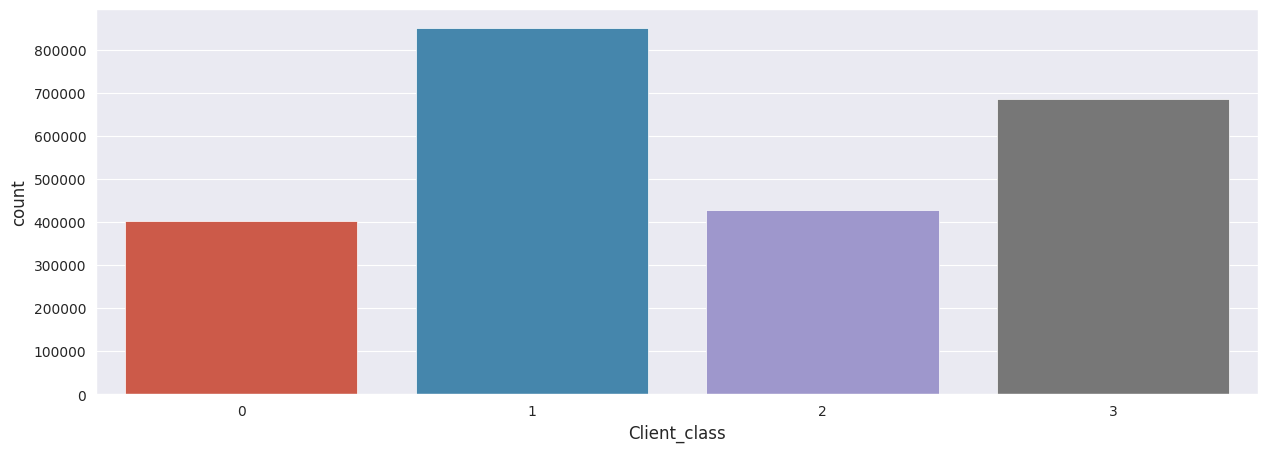

In [ ]:
print(df.Client_class.value_counts())
sns.countplot(x=df.Client_class);

In [ ]:
df.info(null_counts=True)

<ipython-input-38-acd3301a9435>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366180 entries, 0 to 2366179
Data columns (total 47 columns):
 #   Column                               Non-Null Count    Dtype         
---  ------                               --------------    -----         
 0   owner_id                             2366180 non-null  object        
 1   contract_id                          2366180 non-null  object        
 2   issue_dt                             2366180 non-null  object        
 3   close_dt                             1468952 non-null  object        
 4   region_name                          2365381 non-null  object        
 5   city_name                            2365381 non-null  object        
 6   population                           2365381 non-null  float64       
 7   date_of_birth                        2366180 non-null  object        
 8   gender                               2366180 non-null  object        
 9   education                            1886750 non-null  ob

In [ ]:
#Определяем столбцы для удаления

columns_to_drop = ['volume_commitment', 'type_debt', 'days_overdue', 'surety_period', 'mark_kind']
df = df.drop(columns_to_drop, axis=1)

# Выводим измененный DataFrame
print("\nDataFrame после удаления столбцов:")
df.head()



DataFrame после удаления столбцов:


,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,period_interest,psk,balance,current_indebtedness,expired,next_payment,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,beginning_days_delinquency_counting,amount_principal_debt_repaid,availability_support,Client_class
0,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2006-05-27 00:00:00,0.00,RUB,КредитнаяКарта,Активный,2039-08-22 00:00:00,NaN,0.000,141531.65,0.0,0.0,0.0,2015-01-15 00:00:00,2022-08-16 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,2015-01-15 00:00:00,NaN,140070.97,False,0
1,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2013-06-06 00:00:00,168000.00,RUB,КредитНаличнымиНецелевой,СчетЗакрыт,2018-06-18 00:00:00,NaN,0.000,268860.28,0.0,0.0,0.0,2018-06-18 00:00:00,2018-06-20 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,3240.15,2018-06-18 00:00:00,NaN,168000.00,False,0
2,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2014-12-18 00:00:00,29356.04,RUB,Потребительский,СчетЗакрыт,2015-12-17 00:00:00,NaN,40.998,39779.33,0.0,0.0,0.0,2015-12-17 00:00:00,2015-12-30 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,2015-12-17 00:00:00,NaN,29356.04,False,0
3,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2015-11-13 00:00:00,15620.00,RUB,Потребительский,СчетЗакрыт,2016-11-14 00:00:00,NaN,0.000,0.00,0.0,0.0,0.0,2016-10-13 00:00:00,2016-10-13 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,1157.42,2016-10-13 00:00:00,NaN,0.00,False,0
4,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2015-12-07 00:00:00,32000.00,RUB,КредитнаяКарта,СчетЗакрыт,2021-10-01 00:00:00,NaN,29.768,186130.59,0.0,0.0,0.0,2021-08-16 00:00:00,2021-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,2021-10-01 00:00:00,NaN,128642.19,False,0


In [ ]:
#Определяем столбцы для удаления

columns_to_drop = ['period_interest','beginning_days_delinquency_counting', 'next_payment']
df = df.drop(columns_to_drop, axis=1)

# Выводим измененный DataFrame
print("\nDataFrame после удаления столбцов:")
df



DataFrame после удаления столбцов:


,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,psk,balance,current_indebtedness,expired,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
0,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2006-05-27 00:00:00,0.00,RUB,КредитнаяКарта,Активный,2039-08-22 00:00:00,0.000,141531.65,0.0,0.0,2015-01-15 00:00:00,2022-08-16 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,2015-01-15 00:00:00,140070.97,False,0
1,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2013-06-06 00:00:00,168000.00,RUB,КредитНаличнымиНецелевой,СчетЗакрыт,2018-06-18 00:00:00,0.000,268860.28,0.0,0.0,2018-06-18 00:00:00,2018-06-20 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,3240.15,2018-06-18 00:00:00,168000.00,False,0
2,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2014-12-18 00:00:00,29356.04,RUB,Потребительский,СчетЗакрыт,2015-12-17 00:00:00,40.998,39779.33,0.0,0.0,2015-12-17 00:00:00,2015-12-30 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,2015-12-17 00:00:00,29356.04,False,0
3,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2015-11-13 00:00:00,15620.00,RUB,Потребительский,СчетЗакрыт,2016-11-14 00:00:00,0.000,0.00,0.0,0.0,2016-10-13 00:00:00,2016-10-13 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,1157.42,2016-10-13 00:00:00,0.00,False,0
4,004df65f-5039-4786-a5e2-cc298f28eeaa,c3bb2aac-4e33-11ed-b81f-3cfdfed12dbd,2022-10-17 00:00:00,2022-11-19 00:00:00,Архангельская область,г. Северодвинск,182291.0,1981-10-29 00:00:00,Женский,NaN,сотрудники крупного бизнеса,2022-10-17,1d0284ca-4e32-11ed-b80c-3cfdfed12971,2015-12-07 00:00:00,32000.00,RUB,КредитнаяКарта,СчетЗакрыт,2021-10-01 00:00:00,29.768,186130.59,0.0,0.0,2021-08-16 00:00:00,2021-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,2021-10-01 00:00:00,128642.19,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366175,fffe0abf-847c-4195-86f8-9b71732acfd6,bf570d2c-b3d6-11ec-b81f-3cfdfed12dbd,2022-04-04 00:00:00,NaN,Архангельская область,г. Северодвинск,182291.0,1998-03-07 00:00:00,Мужской,NaN,NaN,2022-04-04,30f70836-b3d5-11ec-b80c-3cfdfed12971,2021-04-19 00:00:00,18278.00,RUB,КредитнаяКарта,СчетЗакрыт,2021-09-20 00:00:00,18.408,19793.00,0.0,0.0,2021-09-29 00:00:00,2021-10-06 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,2021-09-29 00:00:00,0.00,0.0,3
2366176,fffe0abf-847c-4195-86f8-9b71732acfd6,bf570d2c-b3d6-11ec-b81f-3cfdfed12dbd,2022-04-04 00:00:00,NaN,Архангельская область,г. Северодвинск,182291.0,1998-03-07 00:00:00,Мужской,NaN,NaN,2022-04-04,30f70836-b3d5-11ec-b80c-3cfdfed12971,2021-02-21 00:00:00,10000.00,RUB,Микрокредит,СчетЗакрыт,2021-04-16 00:00:00,365.000,153

owner_id                                0.0
contract_id                             0.0
issue_dt                                0.0
close_dt                               38.0
region_name                             0.0
city_name                               0.0
population                              0.0
date_of_birth                           0.0
gender                                  0.0
education                              20.0
position                                4.0
dt_nbki                                 0.0
id_nbki                                 0.0
issued                                  0.0
amount                                  0.0
currency                                0.0
type_credit                             0.0
status_credit                           0.0
period                                  0.0
psk                                     0.0
balance                                 0.0
current_indebtedness                    0.0
expired                         

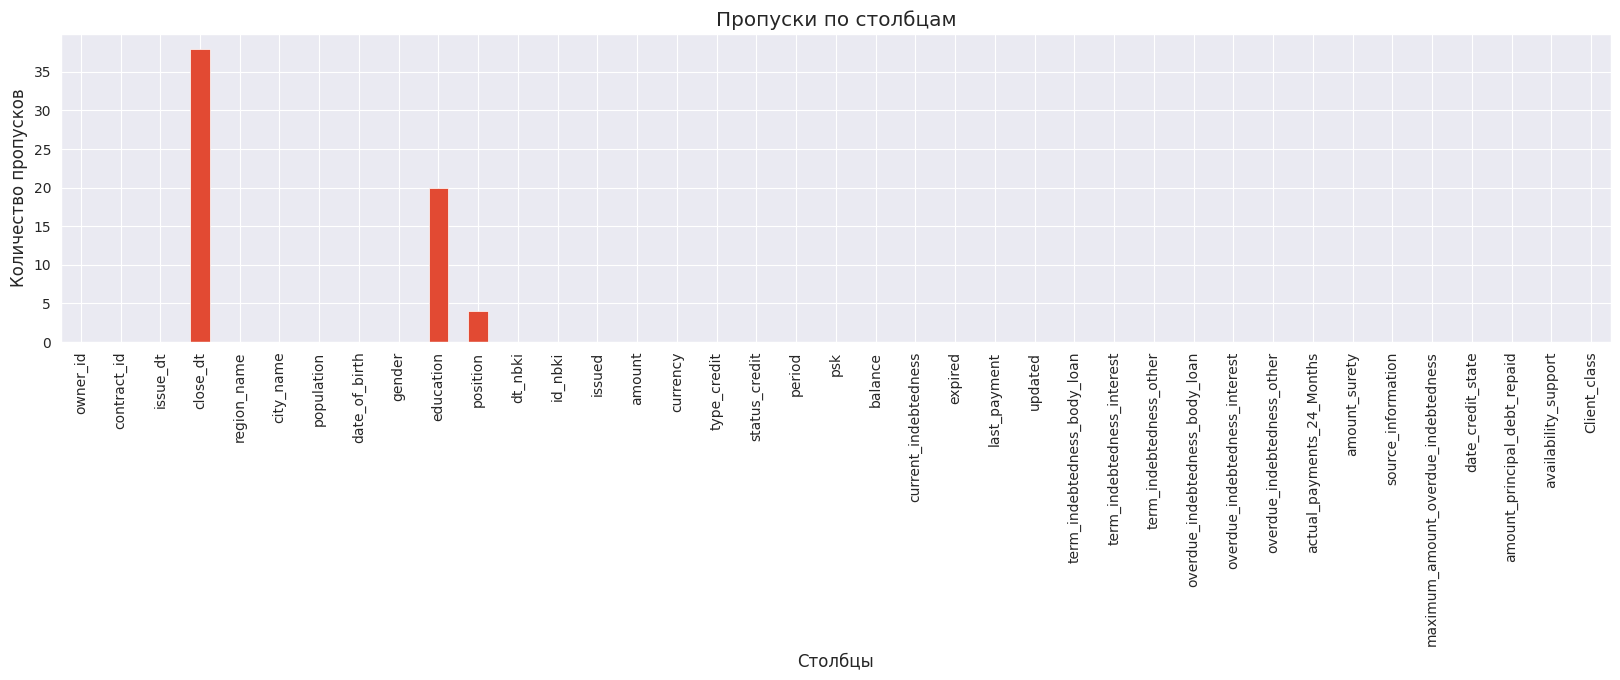

In [ ]:
missing_percentages = round(df.isnull().mean() * 100)
print(missing_percentages)

# Отрисовываем график
plt.figure(figsize=(20, 4))
missing_percentages.plot(kind='bar')
plt.title('Пропуски по столбцам')
plt.xlabel('Столбцы')
plt.ylabel('Количество пропусков')
plt.show()

### Предобработка

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366180 entries, 0 to 2366179
Data columns (total 39 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   owner_id                             object        
 1   contract_id                          object        
 2   issue_dt                             object        
 3   close_dt                             object        
 4   region_name                          object        
 5   city_name                            object        
 6   population                           float64       
 7   date_of_birth                        object        
 8   gender                               object        
 9   education                            object        
 10  position                             object        
 11  dt_nbki                              datetime64[ns]
 12  id_nbki                              object        
 13  issued                     

owner_id                                0.0
contract_id                             0.0
issue_dt                                0.0
close_dt                               38.0
region_name                             0.0
city_name                               0.0
population                              0.0
date_of_birth                           0.0
gender                                  0.0
education                              20.0
position                                4.0
dt_nbki                                 0.0
id_nbki                                 0.0
issued                                  0.0
amount                                  0.0
currency                                0.0
type_credit                             0.0
status_credit                           0.0
period                                  0.0
psk                                     0.0
balance                                 0.0
current_indebtedness                    0.0
expired                         

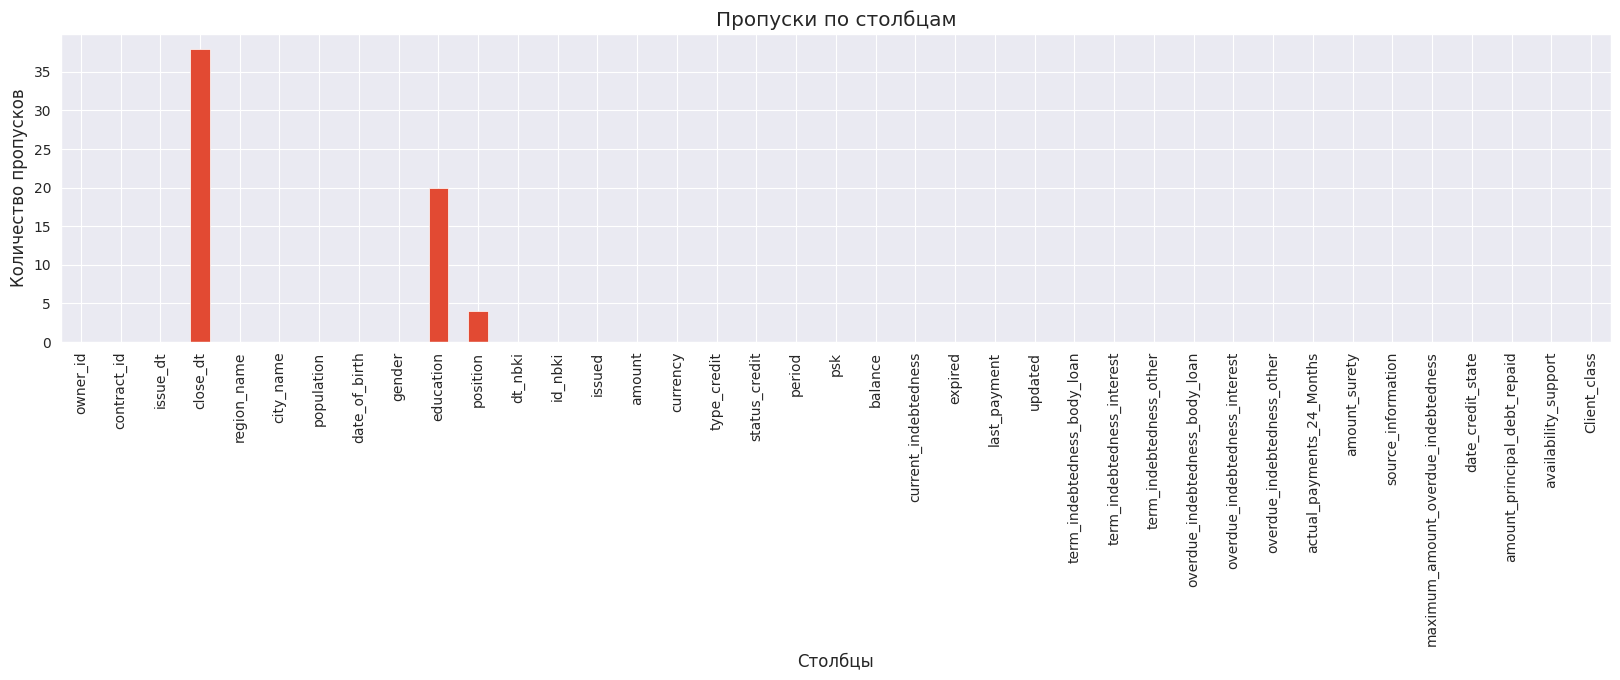

In [ ]:
missing_percentages = round(df.isnull().mean() * 100)
print(missing_percentages)

# Отрисовываем график
plt.figure(figsize=(20, 4))
missing_percentages.plot(kind='bar')
plt.title('Пропуски по столбцам')
plt.xlabel('Столбцы')
plt.ylabel('Количество пропусков')
plt.show()

In [ ]:
df = df.fillna(0)

In [ ]:
df. isnull() .sum() .sum()

0

In [ ]:
df.shape

(1708712, 39)

In [ ]:
df.agg(['nunique']).transpose()

,nunique
owner_id,35280
contract_id,41800
issue_dt,1496
close_dt,1465
region_name,71
city_name,808
population,804
date_of_birth,16351
gender,2
education,8


1    850415
3    685192
2    427178
0    403395
Name: Client_class, dtype: int64


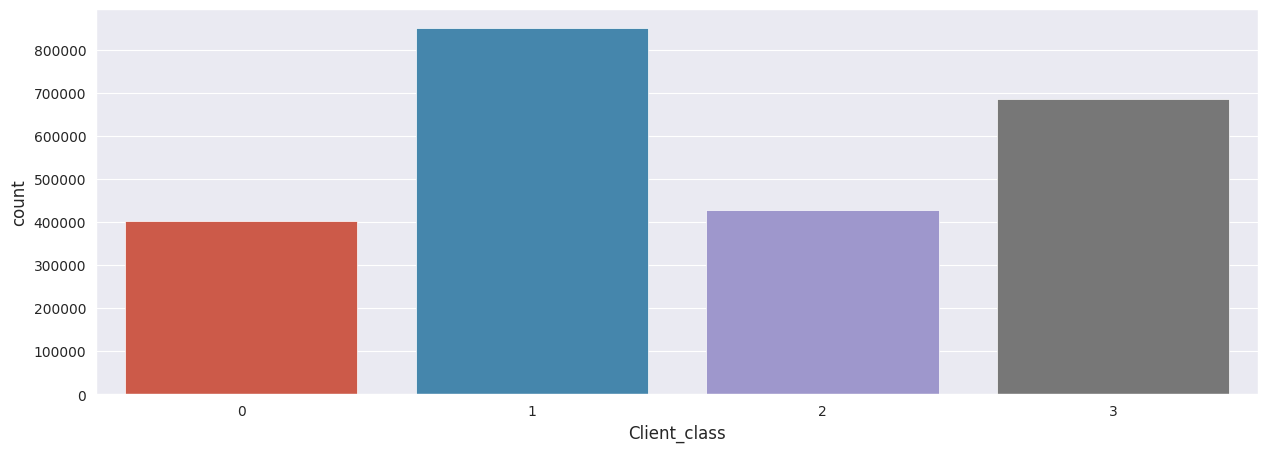

In [ ]:
print(df.Client_class.value_counts())
sns.countplot(x=df.Client_class);

In [ ]:
# Выбор столбцов, которые нужно преобразовать
columns_to_encode = ['amount', 'psk', 'balance', 'term_indebtedness_body_loan', 'overdue_indebtedness_body_loan', 'maximum_amount_overdue_indebtedness', 'amount_principal_debt_repaid']

# Замена запятой на точку
df[columns_to_encode] = df[columns_to_encode].replace(',', '.', regex=True)

# Приведение выбранных столбцов к типу float64
df[columns_to_encode] = df[columns_to_encode].astype('float64')

In [ ]:
df['population'].value_counts()

182291.0     527948
32592.0       23212
64176.0       22893
243536.0      17920
301572.0      16871
              ...  
12408.0          73
1156659.0        70
43191.0          69
15102.0          59
11312.0           1
Name: population, Length: 804, dtype: int64

In [ ]:
df['population'] = df['population'].astype(int)  #Меняем тип данных population на int

In [ ]:
df.info()             # Тип столбца population также изменилось

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708712 entries, 0 to 1708711
Data columns (total 39 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   owner_id                             object 
 1   contract_id                          object 
 2   issue_dt                             object 
 3   close_dt                             object 
 4   region_name                          object 
 5   city_name                            object 
 6   population                           int64  
 7   date_of_birth                        object 
 8   gender                               object 
 9   education                            object 
 10  position                             object 
 11  dt_nbki                              object 
 12  id_nbki                              object 
 13  issued                               object 
 14  amount                               float64
 15  currency                        

In [ ]:
df['amount'].unique()     # Проверка изменений

array([     0.  , 168000.  ,  29356.04, ..., 121616.  , 104249.  ,
         2161.  ])

### Обработка данных о дате

In [ ]:
df['last_payment'].value_counts()

1900-01-02 00:00:00        110041
1900-02-01 00:00:00         83688
1899-12-29 00:00:00         44939
1900-01-02 00:00:00.000     11514
2022-09-15 00:00:00          2676
                            ...  
2005-08-19 00:00:00             1
2022-12-06 00:00:00.000         1
2022-06-21 00:00:00.000         1
2010-08-29 00:00:00             1
2006-05-14 00:00:00             1
Name: last_payment, Length: 8352, dtype: int64

In [ ]:
#df['close_dt'] = df['close_dt'].fillna(0)

In [ ]:
# Преобразование колонок с датами в формат типа unixtime

date_columns = ['issue_dt', 'close_dt', 'date_of_birth','dt_nbki', 'issued', 'period','last_payment', 'updated', 'date_credit_state']

for column in date_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce').astype(int) // 10**9


In [ ]:
df['date_credit_state'].unique()

array([1421280000, 1529280000, 1450310400, ..., 1126310400, 1146182400,
       1147564800])

In [ ]:
df_copy = df.copy()

In [ ]:
# Удаляем некорректные значения

#date_columns = ['issue_dt', 'close_dt', 'date_of_birth','dt_nbki', 'issued', 'period','last_payment', 'updated', 'date_credit_state']
#for date in date_columns:
#    df = df[df[date] >= 0]
date_columns = ['issue_dt', 'close_dt', 'date_of_birth','dt_nbki', 'issued', 'period','last_payment', 'updated', 'date_credit_state']
for date in date_columns:
    df.loc[df[date] <= 0, date] = 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366180 entries, 0 to 2366179
Data columns (total 39 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   owner_id                             object 
 1   contract_id                          object 
 2   issue_dt                             int64  
 3   close_dt                             int64  
 4   region_name                          object 
 5   city_name                            object 
 6   population                           int64  
 7   date_of_birth                        int64  
 8   gender                               object 
 9   education                            object 
 10  position                             object 
 11  dt_nbki                              int64  
 12  id_nbki                              object 
 13  issued                               int64  
 14  amount                               float64
 15  currency                        

### Встраивание id клиентов

In [ ]:

from sklearn.preprocessing import LabelEncoder

# Кодирование owner_id, contract_id, id_nbki
label_encoder = LabelEncoder()
df['owner_id'] = label_encoder.fit_transform(df['owner_id'])
df['contract_id'] = label_encoder.fit_transform(df['contract_id'])
df['id_nbki'] = label_encoder.fit_transform(df['id_nbki'])



In [ ]:
df.head(3)

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,currency,type_credit,status_credit,period,psk,balance,current_indebtedness,expired,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
0,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,0,сотрудники крупного бизнеса,1665964800,4492,1148688000,0.00,RUB,КредитнаяКарта,Активный,2197584000,0.000,141531.65,0.0,0.0,1421280000,1660608000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,1421280000,140070.97,False,0
1,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,0,сотрудники крупного бизнеса,1665964800,4492,1370476800,168000.00,RUB,КредитНаличнымиНецелевой,СчетЗакрыт,1529280000,0.000,268860.28,0.0,0.0,1529280000,1529452800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,3240.15,1529280000,168000.00,False,0
2,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,0,сотрудники крупного бизнеса,1665964800,4492,1418860800,29356.04,RUB,Потребительский,СчетЗакрыт,1450310400,40.998,39779.33,0.0,0.0,1450310400,1451433600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,1450310400,29356.04,False,0


### Работа с категориальными данными

In [ ]:
# Вывод столбцов типа "объект"
object_columns = df.select_dtypes(include=['object'])
print(object_columns.columns)

Index(['region_name', 'city_name', 'gender', 'education', 'position', 'currency', 'type_credit', 'status_credit', 'source_information', 'availability_support'], dtype='object')


### Region name

In [ ]:
df['region_name'] = df['region_name'].astype ('category')


In [ ]:
df['region_name'].value_counts ()

Архангельская область    581930
Краснодарский край       114055
Мурманская область        86595
Белгородская область      74139
Владимирская область      67527
                          ...  
Кабардино-Балкария         2625
Республика Калмыкия        2150
Еврейская АО               1750
Адыгея республика           905
0                           799
Name: region_name, Length: 71, dtype: int64

In [ ]:
# Удаляем все строки, содержаие значение 0
df = df[df['region_name'] != 0]

In [ ]:
df.shape

(2365381, 39)

1    850045
3    685018
2    427093
0    403225
Name: Client_class, dtype: int64


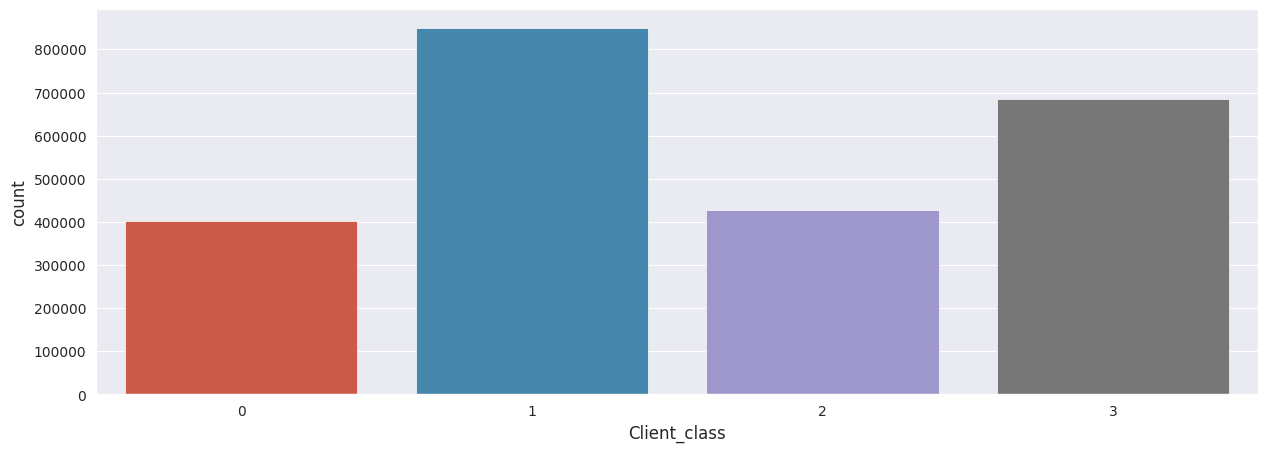

In [ ]:
print(df.Client_class.value_counts())
sns.countplot(x=df.Client_class);

### Population

In [ ]:
df['population'].value_counts()

182291    386522
11103      55256
64176      17435
24131      15290
27788      14468
           ...  
43191         34
27189         32
12408         28
9615          25
11312          1
Name: population, Length: 803, dtype: int64

In [ ]:

df['population'] = df['population'].astype(int)  #Меняем тип данных population на int

### Education

In [ ]:
df['education'].unique()

array([0, 'Высшее', 'СреднеТехническое', 'НеполноеСреднее', 'Среднее',
       'НеполноеВысшее', 'НесколькоВысших', 'УченаяСтепень'], dtype=object)

In [ ]:
df['education'] = df['education'].replace(0, 'Неизвестно')

In [ ]:
df['education'].unique()

array(['Неизвестно', 'Высшее', 'СреднеТехническое', 'НеполноеСреднее',
       'Среднее', 'НеполноеВысшее', 'НесколькоВысших', 'УченаяСтепень'],
      dtype=object)

### Position

In [ ]:
df['position'].unique()

array(['сотрудники крупного бизнеса', 'сотрудник малого бизнеса',
       'специалист', 'рабочий', 0, 'индивидуальный предприниматель (ип)',
       'работник бюджетной сферы', 'муниципальный служащий',
       'сотрудник градообразующего предприятия', 'госслужащий',
       'самозанятый', 'руководитель', 'технический специалист',
       'работник социальной сферы', 'работник промышленных предприятий',
       'пенсионер', 'прочее', 'работник с/х', 'военнослужащий', 'сварщик',
       'разнорабочий', 'судебная власть, права человека', 'маляр',
       'водитель'], dtype=object)

In [ ]:
df['position'] = df['position'].replace(0, 'неопределено')

In [ ]:
df['position'].unique()

array(['сотрудники крупного бизнеса', 'сотрудник малого бизнеса',
       'специалист', 'рабочий', 'неопределено',
       'индивидуальный предприниматель (ип)', 'работник бюджетной сферы',
       'муниципальный служащий', 'сотрудник градообразующего предприятия',
       'госслужащий', 'самозанятый', 'руководитель',
       'технический специалист', 'работник социальной сферы',
       'работник промышленных предприятий', 'пенсионер', 'прочее',
       'работник с/х', 'военнослужащий', 'сварщик', 'разнорабочий',
       'судебная власть, права человека', 'маляр', 'водитель'],
      dtype=object)

In [ ]:
df['position'].value_counts()

пенсионер                                 826655
сотрудник малого бизнеса                  280245
рабочий                                   251687
специалист                                148345
прочее                                    119987
работник промышленных предприятий         111340
сотрудники крупного бизнеса               109768
работник бюджетной сферы                  104054
неопределено                              100434
муниципальный служащий                     65659
госслужащий                                51645
индивидуальный предприниматель (ип)        46777
руководитель                               36607
работник с/х                               33662
работник социальной сферы                  23716
военнослужащий                             21630
самозанятый                                16412
технический специалист                      9657
сотрудник градообразующего предприятия      5627
сварщик                                      691
судебная власть, пра

### Source information

In [ ]:
df['source_information'].value_counts()

МФО                              1461836
Банк                              215611
Коллекторы                         17782
КПК                                 9016
Другой                              2317
Розница                              852
ЖилищныеКредиты                      637
0                                    627
Ломбард                               17
Брокер                                15
ИндивидуальныйПредприниматель          1
ФинансоваяКомпания                     1
Name: source_information, dtype: int64

In [ ]:
df['source_information'] = df['source_information'].replace(0, 'Неизвестно')

In [ ]:
df['source_information'].value_counts()

МФО                              1461836
Банк                              215611
Коллекторы                         17782
КПК                                 9016
Другой                              2317
Розница                              852
ЖилищныеКредиты                      637
Неизвестно                           627
Ломбард                               17
Брокер                                15
ИндивидуальныйПредприниматель          1
ФинансоваяКомпания                     1
Name: source_information, dtype: int64

### Status credit
#### Приведение столбца со статусом кредита к бинарной классификации

In [ ]:
df['status_credit'].value_counts()

СчетЗакрыт                                 1393240
Активный                                    192283
Просрочен                                    75660
ПереданНаОбслуживаниеВДругуюОрганизацию      37560
ПередачаДанныхПрекращена                      5078
ПроблемыСВозвратом                            2590
0                                             1008
Рефинансирован                                 771
СписанСБаланса                                 175
Спор                                           114
Банкротство                                    110
ОплаченЗаСчетОбеспечения                        74
ПринудительноеИсполнение                        38
Расторгнут                                      11
Name: status_credit, dtype: int64

In [ ]:
col_to_replace_on0 =  ['Просрочен', 'Рефинансирован', 'Банкротство', 'ПринудительноеИсполнение', 'ПроблемыСВозвратом', 'Спор', 'Расторгнут']
df['status_credit'] = df['status_credit'].replace (col_to_replace_on0, 'Плохой')


In [ ]:
col_to_replace_on1 =  ['СчетЗакрыт', 'Активный', 'ПереданНаОбслуживаниеВДругуюОрганизацию', 'ПередачаДанныхПрекращена', 'СписанСБаланса','ОплаченЗаСчетОбеспечения']
df['status_credit'] = df['status_credit'].replace (col_to_replace_on1, 'Хороший')


In [ ]:
df['status_credit'] = df['status_credit'].replace(0, 'СтатусНеизвестен')

In [ ]:
df['status_credit'].value_counts()

Хороший             1628410
Плохой                79294
СтатусНеизвестен       1008
Name: status_credit, dtype: int64

### Currency

In [ ]:
df['currency'].value_counts()

RUB    2364488
0          871
USD         20
EUR          2
Name: currency, dtype: int64

In [ ]:
df_copy = df.copy()

In [ ]:
#df = df_copy

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708712 entries, 0 to 1708711
Data columns (total 39 columns):
 #   Column                               Dtype   
---  ------                               -----   
 0   owner_id                             int64   
 1   contract_id                          int64   
 2   issue_dt                             int64   
 3   close_dt                             int64   
 4   region_name                          category
 5   city_name                            object  
 6   population                           int64   
 7   date_of_birth                        int64   
 8   gender                               object  
 9   education                            object  
 10  position                             object  
 11  dt_nbki                              int64   
 12  id_nbki                              int64   
 13  issued                               int64   
 14  amount                               float64 
 15  currency       

In [ ]:
df['currency'].unique()

array(['RUB', 0, 'USD', 'EUR'], dtype=object)

In [ ]:
# Преобразование значений в колонке currency к строковому типу (если они не являются строками)
df['currency'] = df['currency'].astype(str)

# Замена NaN значений пустыми строками
df['currency'].fillna('', inplace=True)

# Удаление строк, содержащих '0', 'usd' или 'eur' в колонке currency
df = df[~df['currency'].str.contains('0|USD|EUR')]


In [ ]:
df['currency'].value_counts()

RUB    1708073
Name: currency, dtype: int64

In [ ]:
df = df.drop(columns='currency')          #удаление столбца валюта

In [ ]:
df.head()

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,type_credit,status_credit,period,psk,balance,current_indebtedness,expired,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
0,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,Неизвестно,сотрудники крупного бизнеса,1665964800,4492,1148688000,0.00,КредитнаяКарта,Активный,2197584000,0.000,141531.65,0.0,0.0,1421280000,1660608000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,1421280000,140070.97,False,0
1,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,Неизвестно,сотрудники крупного бизнеса,1665964800,4492,1370476800,168000.00,КредитНаличнымиНецелевой,СчетЗакрыт,1529280000,0.000,268860.28,0.0,0.0,1529280000,1529452800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,3240.15,1529280000,168000.00,False,0
2,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,Неизвестно,сотрудники крупного бизнеса,1665964800,4492,1418860800,29356.04,Потребительский,СчетЗакрыт,1450310400,40.998,39779.33,0.0,0.0,1450310400,1451433600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,1450310400,29356.04,False,0
3,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,Неизвестно,сотрудники крупного бизнеса,1665964800,4492,1447372800,15620.00,Потребительский,СчетЗакрыт,1479081600,0.000,0.00,0.0,0.0,1476316800,1476316800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,1157.42,1476316800,0.00,False,0
4,112,32041,1665964800,1668816000,Архангельская область,г. Северодвинск,182291,373161600,Женский,Неизвестно,сотрудники крупного бизнеса,1665964800,4492,1449446400,32000.00,КредитнаяКарта,СчетЗакрыт,1633046400,29.768,186130.59,0.0,0.0,1629072000,1633046400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Банк,0.00,1633046400,128642.19,False,0


### Availability support

In [ ]:
df['availability_support'].value_counts()

False    2353264
True       11224
Name: availability_support, dtype: int64

In [ ]:
# Преобразование значений в колонке currency к строковому типу (если они не являются строками)
df['availability_support'] = df['availability_support'].astype(str)

# Замена NaN значений пустыми строками
df['availability_support'].replace('0.0', 'No', inplace=True)
df['availability_support'].replace('1.0', 'Yes', inplace=True)
df['availability_support'].replace('False', 'No', inplace=True)
df['availability_support'].replace('True', 'Yes', inplace=True)

# Преобразование значений в колонке к категориальному  типу
df['availability_support'] = df['availability_support'].astype('category')


In [ ]:
df['availability_support'].value_counts()

False    2353264
True       11224
Name: availability_support, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708073 entries, 0 to 1708711
Data columns (total 38 columns):
 #   Column                               Dtype   
---  ------                               -----   
 0   owner_id                             int64   
 1   contract_id                          int64   
 2   issue_dt                             int64   
 3   close_dt                             int64   
 4   region_name                          category
 5   city_name                            object  
 6   population                           int64   
 7   date_of_birth                        int64   
 8   gender                               object  
 9   education                            object  
 10  position                             object  
 11  dt_nbki                              int64   
 12  id_nbki                              int64   
 13  issued                               int64   
 14  amount                               float64 
 15  type_credit    

### Работа над остальными столбцами типа object

In [ ]:
# Выбираем столбцы типа 'object'
object_columns = df.select_dtypes(include=['object'])

# Выводим только названия столбцов
column_names = object_columns.columns.tolist()
print(column_names)

# Приводим выбранные столбцы к категориальному типу
df[column_names] = df[column_names].astype('category')

['city_name', 'gender', 'education', 'position', 'type_credit', 'status_credit', 'source_information', 'availability_support']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708073 entries, 0 to 1708711
Data columns (total 38 columns):
 #   Column                               Dtype   
---  ------                               -----   
 0   owner_id                             int64   
 1   contract_id                          int64   
 2   issue_dt                             int64   
 3   close_dt                             int64   
 4   region_name                          category
 5   city_name                            category
 6   population                           int64   
 7   date_of_birth                        int64   
 8   gender                               category
 9   education                            category
 10  position                             category
 11  dt_nbki                              int64   
 12  id_nbki                              int64   
 13  issued                               int64   
 14  amount                               float64 
 15  type_credit    

In [ ]:
# Выбор столбцов, которые нужно преобразовать
columns_to_encode = ['region_name', 'city_name', 'gender', 'education', 'position', 'type_credit', 'status_credit', 'source_information', 'availability_support']

df[columns_to_encode] = df[columns_to_encode].apply(lambda x: x.astype('category').cat.codes)

In [ ]:
df.head()

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,type_credit,status_credit,period,psk,balance,current_indebtedness,expired,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
0,112,32041,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,4492,1148688000,0.00,12,1,2197584000,0.000,141531.65,0.0,0.0,1421280000,1660608000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1421280000,140070.97,0,0
1,112,32041,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,4492,1370476800,168000.00,11,13,1529280000,0.000,268860.28,0.0,0.0,1529280000,1529452800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3240.15,1529280000,168000.00,0,0
2,112,32041,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,4492,1418860800,29356.04,21,13,1450310400,40.998,39779.33,0.0,0.0,1450310400,1451433600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1450310400,29356.04,0,0
3,112,32041,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,4492,1447372800,15620.00,21,13,1479081600,0.000,0.00,0.0,0.0,1476316800,1476316800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1157.42,1476316800,0.00,0,0
4,112,32041,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,4492,1449446400,32000.00,12,13,1633046400,29.768,186130.59,0.0,0.0,1629072000,1633046400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1633046400,128642.19,0,0


In [ ]:
df.shape

(1708073, 38)

In [ ]:
df_copy = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2364488 entries, 0 to 2366179
Data columns (total 38 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   owner_id                             int64  
 1   contract_id                          int64  
 2   issue_dt                             int64  
 3   close_dt                             int64  
 4   region_name                          int8   
 5   city_name                            int16  
 6   population                           int64  
 7   date_of_birth                        int64  
 8   gender                               int8   
 9   education                            int8   
 10  position                             int8   
 11  dt_nbki                              int64  
 12  id_nbki                              int64  
 13  issued                               int64  
 14  amount                               float64
 15  type_credit                     

In [ ]:
df

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,type_credit,status_credit,period,psk,balance,current_indebtedness,expired,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
0,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1148688000,0.00,12,2,2197584000,0.000,141531.65,0.0,0.0,1421280000,1660608000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1421280000,140070.97,0,0
1,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1370476800,168000.00,11,2,1529280000,0.000,268860.28,0.0,0.0,1529280000,1529452800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3240.15,1529280000,168000.00,0,0
2,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1418860800,29356.04,21,2,1450310400,40.998,39779.33,0.0,0.0,1450310400,1451433600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1450310400,29356.04,0,0
3,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1447372800,15620.00,21,2,1479081600,0.000,0.00,0.0,0.0,1476316800,1476316800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1157.42,1476316800,0.00,0,0
4,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1449446400,32000.00,12,2,1633046400,29.768,186130.59,0.0,0.0,1629072000,1633046400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1633046400,128642.19,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708707,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1659398400,5000.00,14,2,1661212800,365.000,6102.73,0.0,0.0,1661299200,1661385600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1661385600,5000.00,0,3
1708708,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1659484800,6000.00,14,2,1661299200,361.000,6000.00,0.0,0.0,1661212800,1661212800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1661212800,6000.00,0,3
1708709,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1659916800,7000.00,14,2,1662422400,0.000,7000.00,0.0,0.0,1662076800,1662076800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1662076800,7000.00,0,3
1708710,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1661212800,8000.00,14,2,1663891200,361.000,10455.00,0.0,0.0,1663545600,1663545600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1663545600,8000.00,0,3


1    849869
3    684583
2    426997
0    403039
Name: Client_class, dtype: int64


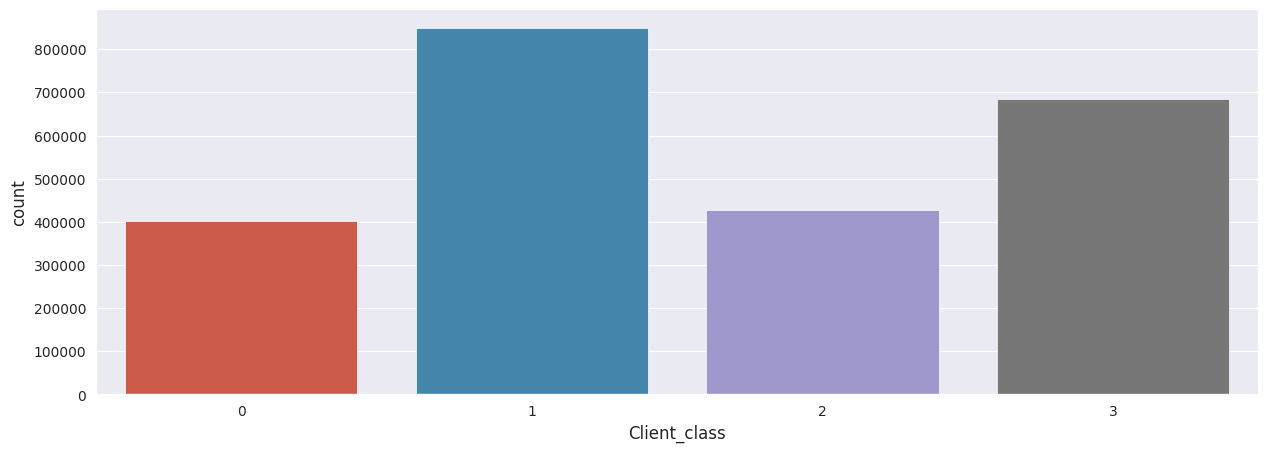

In [ ]:
print(df.Client_class.value_counts())
sns.countplot(x=df.Client_class);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708073 entries, 0 to 1708072
Data columns (total 38 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   owner_id                             int64  
 1   contract_id                          int64  
 2   issue_dt                             int64  
 3   close_dt                             int64  
 4   region_name                          int64  
 5   city_name                            int64  
 6   population                           int64  
 7   date_of_birth                        int64  
 8   gender                               int64  
 9   education                            int64  
 10  position                             int64  
 11  dt_nbki                              int64  
 12  id_nbki                              int64  
 13  issued                               int64  
 14  amount                               float64
 15  type_credit                     

In [ ]:
# Не запускать

# Приводим все типы данных к категориальному типу. Смотрим размерность базы

# Выбираем столбцы типа 'object'
object_columns = df.select_dtypes(include=['float64', 'int64', 'int16','int8'])

# Выводим только названия столбцов
column_names = object_columns.columns.tolist()
#print(column_names)

# Приводим выбранные столбцы к категориальному типу
df[column_names] = df[column_names].astype('category')

In [ ]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2364488 entries, 0 to 2366179
Data columns (total 38 columns):
 #   Column                               Dtype   
---  ------                               -----   
 0   owner_id                             category
 1   contract_id                          category
 2   issue_dt                             category
 3   close_dt                             category
 4   region_name                          category
 5   city_name                            category
 6   population                           category
 7   date_of_birth                        category
 8   gender                               category
 9   education                            category
 10  position                             category
 11  dt_nbki                              category
 12  id_nbki                              category
 13  issued                               category
 14  amount                               category
 15  type_credit    

In [ ]:
df

,owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,type_credit,status_credit,period,psk,balance,current_indebtedness,expired,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support,Client_class
0,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1148688000,0.00,12,2,2197584000,0.000,141531.65,0.0,0.0,1421280000,1660608000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1421280000,140070.97,0,0
1,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1370476800,168000.00,11,2,1529280000,0.000,268860.28,0.0,0.0,1529280000,1529452800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3240.15,1529280000,168000.00,0,0
2,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1418860800,29356.04,21,2,1450310400,40.998,39779.33,0.0,0.0,1450310400,1451433600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1450310400,29356.04,0,0
3,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1447372800,15620.00,21,2,1479081600,0.000,0.00,0.0,0.0,1476316800,1476316800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1157.42,1476316800,0.00,0,0
4,104,23492,1665964800,1668816000,3,468,182291,373161600,0,1,20,1665964800,3330,1449446400,32000.00,12,2,1633046400,29.768,186130.59,0.0,0.0,1629072000,1633046400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,1633046400,128642.19,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708068,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1659398400,5000.00,14,2,1661212800,365.000,6102.73,0.0,0.0,1661299200,1661385600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1661385600,5000.00,0,3
1708069,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1659484800,6000.00,14,2,1661299200,361.000,6000.00,0.0,0.0,1661212800,1661212800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1661212800,6000.00,0,3
1708070,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1659916800,7000.00,14,2,1662422400,0.000,7000.00,0.0,0.0,1662076800,1662076800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1662076800,7000.00,0,3
1708071,21882,29110,1680220800,0,3,468,182291,638496000,1,1,13,1680220800,21271,1661212800,8000.00,14,2,1663891200,361.000,10455.00,0.0,0.0,1663545600,1663545600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.00,1663545600,8000.00,0,3


## Сохранение нормированной общей базы

In [ ]:
# Сохранение датасета

df.to_csv('/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Data/df_4_all_norm.csv', index=False)


In [ ]:
del df1_1, df1_2, df1, df2, df3, df4, df5, df6, df7, df8

## Загрузка очищенной общей базы

In [ ]:
# Загрузка датасета

df = pd.read_csv('/content/drive/MyDrive/Colab/df_4_all.csv')


## Деление на train, val, test выборки

In [ ]:
#test
def split(df, name, test_proportion=0.2, seed=None):

  # Получаем уникальные значения из df
  df_unique_len = df['id_nbki'].nunique()
  df_unique = df['id_nbki'].unique()

  if seed is not None:
    np.random.seed(seed)

  # Выбираем 20% случайных значений из df_unique
  df_sample = np.random.choice(df_unique, size=int(test_proportion*len(df_unique)), replace=False)

  # Фильтруем df по значениям в df_sample
  df_test = df[df['id_nbki'].isin(df_sample)]
  # Фильтруем df по значениям, которых нет в df_sample
  df_train = df[~df['id_nbki'].isin(df_sample)]


  data = [
      ['DataFrame', 'Уникальных значений', 'Отобрали значений', 'Train', 'Test'],
      [name, df_unique_len, df_sample.shape[0], df_train.shape, df_test.shape]
  ]

  table = tabulate(data, tablefmt='grid')
  print(table, end='\n\n')

  return df_train, df_test


df_train, df_test = split(df, 'df', 0.15, seed=42)

+-----------+---------------------+-------------------+---------------+--------------+
| DataFrame | Уникальных значений | Отобрали значений | Train         | Test         |
+-----------+---------------------+-------------------+---------------+--------------+
| df        | 38363               | 5754              | (2005211, 38) | (359277, 38) |
+-----------+---------------------+-------------------+---------------+--------------+



In [ ]:
df_val, df_test = split(df_test, 'df', 0.5, seed=42)

+-----------+---------------------+-------------------+--------------+--------------+
| DataFrame | Уникальных значений | Отобрали значений | Train        | Test         |
+-----------+---------------------+-------------------+--------------+--------------+
| df        | 5754                | 2877              | (180258, 38) | (179019, 38) |
+-----------+---------------------+-------------------+--------------+--------------+



In [ ]:
print(df.shape)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2364488, 38)
(2005211, 38)
(180258, 38)
(179019, 38)


1    719115
3    584214
2    363458
0    338424
Name: Client_class, dtype: int64


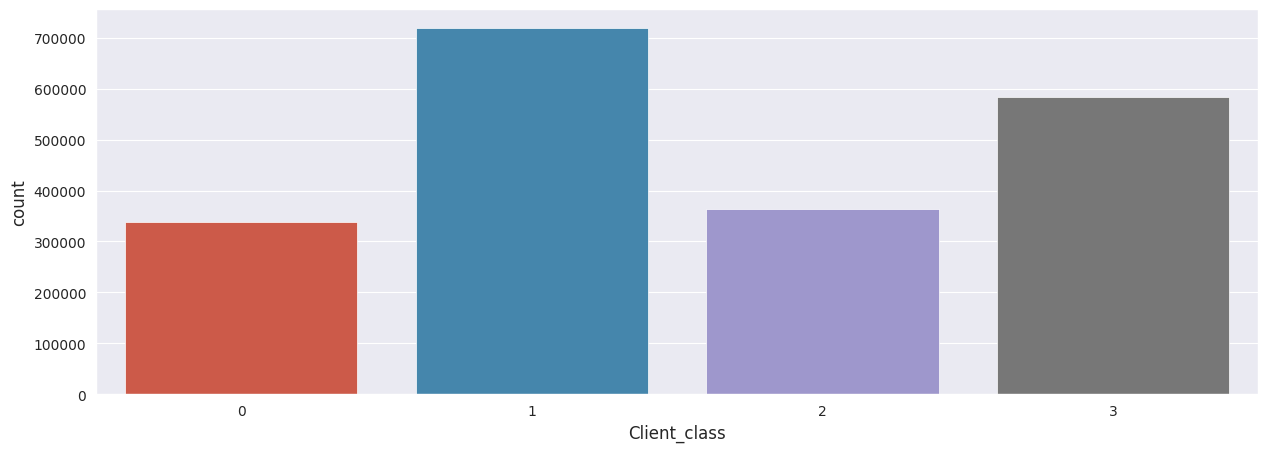

In [ ]:
print(df_train.Client_class.value_counts())
sns.countplot(x=df_train.Client_class);

In [ ]:
del df

In [ ]:
y_train_src = pd.get_dummies(df_train['Client_class'], columns=['Client_class']).to_numpy()
df_train.drop(columns=['Client_class'], inplace=True)
x_train_src = df_train
del df_train
x_train_src = x_train_src.to_numpy()
print(x_train_src.shape)
y_train_src

(2005211, 37)


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
y_val_src = pd.get_dummies(df_val['Client_class'], columns=['Client_class']).to_numpy()
df_val.drop(columns=['Client_class'], inplace=True)
x_val_src = df_val
del df_val
x_val_src = x_val_src.to_numpy()
print(x_val_src.shape)
y_val_src

(180258, 37)


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
y_test_src = pd.get_dummies(df_test['Client_class'], columns=['Client_class']).to_numpy()
df_test.drop(columns=['Client_class'], inplace=True)
x_test_src = df_test
del df_test
x_test_src = x_test_src.to_numpy()
print(x_test_src.shape)
y_test_src

(179019, 37)


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

## Сохранение выборок

In [ ]:
np.save('/content/drive/MyDrive/ML_Models/x_train_src.npy', x_train_src)
np.save('/content/drive/MyDrive/ML_Models/y_train_src.npy', y_train_src)
np.save('/content/drive/MyDrive/ML_Models/x_val_src.npy', x_val_src)
np.save('/content/drive/MyDrive/ML_Models/y_val_src.npy', y_val_src)
np.save('/content/drive/MyDrive/ML_Models/x_test_src.npy', x_test_src)
np.save('/content/drive/MyDrive/ML_Models/y_test_src.npy', y_test_src)

## Загрузка очищенных выборок (4 класса)





In [ ]:
#gdown.download(f"https://drive.google.com/uc?id=143B_XdERzmnxbspXRe49A_R4y6jsmO46", output="/content/4_Classes_85-7.5-7.5.7z.7z", quiet=True)

In [ ]:
!7z x '/content/drive/MyDrive/ForColab/Stazh/1 Scoring/FromAnna/4_Classes_85-7.5-7.5.7z' -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/ForColab/Stazh/1 Scoring/FromAnna/                                                                   1 file, 29377366 bytes (29 MiB)

Extracting archive: /content/drive/MyDrive/ForColab/Stazh/1 Scoring/FromAnna/4_Classes_85-7.5-7.5.7z
--
Path = /content/drive/MyDrive/ForColab/Stazh/1 Scoring/FromAnna/4_Classes_85-7.5-7.5.7z
Type = 7z
Physical Size = 29377366
Headers Size = 286
Method = LZMA2:28
Solid = +
Blocks = 1

  0%      2% 1 - 4_Classes_85-7.5-7.5/test_data.npy                                           

In [ ]:
x_train_src = np.load('/content/drive/MyDrive/ML_Models/x_train_src.npy')
print(x_train_src.shape)
y_train_src = np.load('/content/drive/MyDrive/ML_Models/y_train_src.npy')
print(y_train_src.shape)

(1461850, 37)
(1461850, 4)


In [ ]:
x_val_src = np.load('/content/drive/MyDrive/ML_Models/x_val_src.npy')
print(x_val_src.shape)
y_val_src = np.load('/content/drive/MyDrive/ML_Models/y_val_src.npy')
print(y_val_src.shape)

(126872, 37)
(126872, 4)


In [ ]:
x_test_src = np.load('/content/drive/MyDrive/ML_Models/x_test_src.npy')
print(x_test_src.shape)
y_test_src = np.load('/content/drive/MyDrive/ML_Models/y_test_src.npy')
print(y_test_src.shape)

(119351, 37)
(119351, 4)


## Вспомогательные константы

In [ ]:
# # Инициируем список столбцов датасета - для удобства работы с датасетами
column_names = "owner_id,contract_id,issue_dt,close_dt,region_name,city_name,population,date_of_birth,gender,education,position,dt_nbki,id_nbki,issued,amount,type_credit,status_credit,period,psk,balance,current_indebtedness,expired,last_payment,updated,term_indebtedness_body_loan,term_indebtedness_interest,term_indebtedness_other,overdue_indebtedness_body_loan,overdue_indebtedness_interest,overdue_indebtedness_other,actual_payments_24_Months,amount_surety,source_information,maximum_amount_overdue_indebtedness,date_credit_state,amount_principal_debt_repaid,availability_support".strip().split(',')
len(column_names)

37

## (Опционально) Эксперимент без группировки по столбцу id_nbki

In [ ]:
# Объединяем датасеты, перемешиваем и разбиваем заново на обучающую, валидационную и тестовую
x_train_src, x_test_src, y_train_src, y_test_src = train_test_split(np.vstack((x_train_src, x_val_src, x_test_src)), np.vstack((y_train_src, y_val_src, y_test_src)), test_size=0.15, random_state=44)
x_val_src, x_test_src, y_val_src, y_test_src = train_test_split(x_test_src, y_test_src, test_size=0.5, random_state=44)

## (Опционально) Добавляем разности столбцов

### Возраст на момент запроса кредита

In [ ]:
col1_id = column_names.index("date_of_birth")
col2_id = column_names.index("issued")

In [ ]:
# Добавляем новый столбец в список
column_names.append("dlt.issued-date_of_birth")

In [ ]:
x_train_src = np.hstack((x_train_src, (x_train_src[:, col2_id] - x_train_src[:, col1_id]).reshape(-1, 1)))
x_val_src = np.hstack((x_val_src, (x_val_src[:, col2_id] - x_val_src[:, col1_id]).reshape(-1, 1)))
x_test_src = np.hstack((x_test_src, (x_test_src[:, col2_id] - x_test_src[:, col1_id]).reshape(-1, 1)))
print("Размеры тренировочного датасета", x_train_src.shape)
x_test_src

Размеры тренировочного датасета (2009814, 38)


array([[8.0970000e+03, 3.0143000e+04, 1.6396128e+09, ..., 0.0000000e+00,
        0.0000000e+00, 1.5583968e+09],
       [1.0860000e+04, 1.1436000e+04, 1.6161120e+09, ..., 0.0000000e+00,
        0.0000000e+00, 1.0894176e+09],
       [2.0397000e+04, 2.4228000e+04, 1.6159392e+09, ..., 0.0000000e+00,
        0.0000000e+00, 1.2626496e+09],
       ...,
       [2.6526000e+04, 9.7120000e+03, 1.6668288e+09, ..., 2.0000000e+04,
        0.0000000e+00, 1.1033280e+09],
       [1.4187000e+04, 1.0759000e+04, 1.6647552e+09, ..., 4.9500000e+03,
        0.0000000e+00, 1.5039648e+09],
       [3.9000000e+01, 2.5440000e+03, 1.6373664e+09, ..., 0.0000000e+00,
        0.0000000e+00, 1.1401344e+09]])

## Оценка степени пересечения данных в выборках

In [ ]:
def unique_stats(train, val):
    train_unique = len(set(train.flatten()))
    val_unique = len(set(val.flatten()))

    intersect = len(set(train.flatten()).intersection(set(val.flatten())))

    train_overlap = intersect / train_unique
    val_overlap = intersect / val_unique

    return train_unique, val_unique, train_overlap, val_overlap

In [ ]:
# Нужно ли пропускать солбцы с квадратами значений? (считается, что они во второй половине столбцов)
Skip_Squares = True

In [ ]:
if Skip_Squares:
    _ds1 = x_train_src
    _ds2 = x_val_src
    _ds3 = x_test_src
else:
    _ds1 = x_train_src_Sq
    _ds2 = x_val_src_Sq
    _ds3 = x_test_src_Sq

column_ids = range(_ds1.shape[1])

# Предполагая, что x_train_complex и x_val_complex являются списками numpy массивов
for i in column_ids:
    train_unique, val_unique, train_overlapV, val_overlap = unique_stats(_ds1[:,i], _ds2[:,i])
    _, test_unique, train_overlapT, test_overlap = unique_stats(_ds1[:,i], _ds3[:,i])

    print(f"Столбец '{column_names[i]}' (#{i}):")
    print(f"  Уникальных значений в Train: {train_unique}")
    print(f"  Уникальных значений в Val: {val_unique}")
    print(f"  Уникальных значений в Test: {test_unique}")
    print("  -----------------------------------------------------")
    print(f"  Доля уникальных значений из Train в Val: {(100.0 * train_overlapV):.5f}%")
    print(f"  Доля уникальных значений из Val в Train: {(100.0 * val_overlap):.5f}%")
    print("  -----------------------------------------------------")
    print(f"  Доля уникальных значений из Train в Test: {(100.0 * train_overlapT):.5f}%")
    print(f"  Доля уникальных значений из Test в Train: {(100.0 * test_overlap):.5f}%")
    print()

Столбец 'owner_id' (#0):
  Уникальных значений в Train: 34433
  Уникальных значений в Val: 26499
  Уникальных значений в Test: 26510
  -----------------------------------------------------
  Доля уникальных значений из Train в Val: 76.71710%
  Доля уникальных значений из Val в Train: 99.68678%
  -----------------------------------------------------
  Доля уникальных значений из Train в Test: 76.73453%
  Доля уникальных значений из Test в Train: 99.66805%

Столбец 'contract_id' (#1):
  Уникальных значений в Train: 40831
  Уникальных значений в Val: 31621
  Уникальных значений в Test: 31600
  -----------------------------------------------------
  Доля уникальных значений из Train в Val: 77.19870%
  Доля уникальных значений из Val в Train: 99.68375%
  -----------------------------------------------------
  Доля уникальных значений из Train в Test: 77.15951%
  Доля уникальных значений из Test в Train: 99.69937%

Столбец 'issue_dt' (#2):
  Уникальных значений в Train: 1083
  Уникальных зна

## Квантильное нормирование столбцов

In [ ]:
# обучаем квантильный масштабатор и нормируем датасеты
qts = QuantileTransformer(output_distribution='uniform', random_state=42)
qts.fit(np.vstack((x_train_src, x_val_src, x_test_src)))
x_train_src = qts.transform(x_train_src).astype("float32")
x_val_src = qts.transform(x_val_src).astype("float32")
x_test_src = qts.transform(x_test_src).astype("float32")

## Добавление квадратов столбцов (для увеличения эффективности работы НС)

In [ ]:
# добавляем столбцы квадратами значений и сохраняем в НОВЫЕ датасеты
x_train_src_Sq = np.hstack((x_train_src, x_train_src ** 2))
x_val_src_Sq = np.hstack((x_val_src, x_val_src ** 2))
x_test_src_Sq = np.hstack((x_test_src, x_test_src ** 2))

In [ ]:
x_train_src_Sq[1,:]

array([0.27838865, 0.2881677 , 0.7552553 , 0.8238238 , 0.6496496 ,
       0.8603604 , 0.5820821 , 0.6279478 , 0.        , 0.8323323 ,
       0.6956957 , 0.7427427 , 0.18999179, 0.93330973, 0.4229229 ,
       0.45145145, 0.05355356, 0.8678679 , 0.7442442 , 0.        ,
       0.        , 0.        , 0.        , 0.8998999 , 0.9099099 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.5680681 , 0.        , 0.9074074 ,
       0.        , 0.        , 0.43659666, 0.07750024, 0.08304062,
       0.57041055, 0.67868567, 0.42204463, 0.74022   , 0.33881956,
       0.39431846, 0.        , 0.6927771 , 0.48399252, 0.55166674,
       0.03609688, 0.87106705, 0.1788638 , 0.20380841, 0.00286798,
       0.7531947 , 0.55389947, 0.        , 0.        , 0.        ,
       0.        , 0.8098198 , 0.82793605, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.32270136, 0.        , 0.8233882 , 0.        , 0.     

## Перебор моделей

### Callbacks

In [ ]:
import json
#from keras.saving import saving_lib
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, BackupAndRestore, \
                                       TensorBoard, EarlyStopping, LearningRateScheduler, \
                                       ReduceLROnPlateau, RemoteMonitor, LambdaCallback, \
                                       TerminateOnNaN, CSVLogger, ProgbarLogger
from collections import defaultdict
def get_callbacks(AK_PROJ_NAME, PATH = "/content/drive/MyDrive/AutoMl", min_acc=0.75):
    W_DIR = '/content'
    # Определяем формат даты и времени
    date_format = "%Y-%m-%dT%H"
    # Получаем текущую дату и время до часа
    now = datetime.now().strftime(date_format)
    # Собираем путь с датой и временем
    AK_DIR = W_DIR + '/autokeras_jobs'
    BACKUP_DIR = f"{PATH}/{AK_PROJ_NAME}/{now}/training_backup"
    CHKPOINT_DIR = f"{PATH}/{AK_PROJ_NAME}/{now}/training_chkpoint"
    '''
    tb_callback = TensorBoard(
        AK_DIR,
        histogram_freq=1,
        write_graph=False,
        write_images=True,
        write_steps_per_second=True,
        update_freq="epoch",
        profile_batch=(10,20)
    )
    '''
    reduce_callback_train  = ReduceLROnPlateau(
        monitor="loss",
        factor=0.65,
        patience=4,
        verbose=0,
        min_delta=0.00002,
        cooldown=15,
        min_lr=0.000003,
    )
    reduce_callback_val  = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.75,
        patience=6,
        verbose=0,
        min_delta=0.00002,
        cooldown=15,
        min_lr=0.000003,
    )

    backup_callback = BackupAndRestore(
        BACKUP_DIR,
        #save_freq="epoch",
        #delete_checkpoint=True,
    )

    es_callback = EarlyStopping(
        monitor="loss",
        patience=3,
        verbose=0,
        min_delta=0.0002,
        restore_best_weights=True,
        start_from_epoch=2,
    )

    mc_callback = ModelCheckpoint(
        CHKPOINT_DIR + f'/mdl_{AK_PROJ_NAME}',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_format='tf'
    )

    class SaveBestModelCallback(tf.keras.callbacks.Callback):
        def __init__(self, directory, monitor='val_loss', mode='min', min_delta=0.0002, min_acc=0.5):
            super(SaveBestModelCallback, self).__init__()
            self.directory = directory
            self.monitor = monitor
            self.mode = mode
            self.best_value = -1.0
            self.best_val_acc = min_acc
            self.min_delta = min_delta
            self.min_acc = min_acc
            print(f"SaveBestModelCallback('directory={directory}', monitor='{monitor}', mode='{mode}', min_delta={min_delta}, min_acc={min_acc}) created!")

        def on_epoch_end(self, epoch, logs=None):
            if epoch < 2:
                return
            logs = defaultdict(lambda: -1.0, logs)
            current_value = logs.get(self.monitor)
            cur_v_acc = logs["val_accuracy"]
            cur_acc = logs["accuracy"]
            print(f"Epoch#{epoch}: Accuracies: train={cur_acc}[{cur_acc > self.min_acc}], validation={cur_v_acc}[{cur_v_acc > self.min_acc}], best={self.best_val_acc}")
            if current_value == -1:
                return
            best_acc_only = False
            if \
                    (self.mode == 'min' and ((self.best_value - current_value) >= self.min_delta) and (cur_acc > self.min_acc) and (cur_v_acc > self.min_acc)) or \
                    (self.mode == 'max' and ((current_value - self.best_value) >= self.min_delta) and (cur_acc > self.min_acc) and (cur_v_acc > self.min_acc)) or \
                    (cur_v_acc > self.best_val_acc and (best_acc_only := True)):  # помечаем в  что пришли ТОЛЬКО по лучшей точности на валидационной выбоке
                if best_acc_only:
                    self.best_val_acc = cur_v_acc
                else:
                    self.best_value = current_value
                    if cur_v_acc > self.best_val_acc: self.best_val_acc = cur_v_acc
                self.best_model_epoch = epoch
                best_model = self.model
                name_template = os.path.join(self.directory, f"Mdl_pr{self.model.count_params()}_vA{100 * logs['val_accuracy']:.3f}_vL{logs['val_loss']:.4f}_tA{100 * logs['accuracy']:.3f}_tL{logs['loss']:.4f}_e{str(epoch).zfill(4)}")
                best_model.save(name_template + ".keras", save_format='keras')
                print(f"Epoch {epoch}: saved model ({name_template})\n")

        def on_train_end(self, logs=None):
            logs = defaultdict(lambda: -1.0, logs)
            name_template = os.path.join(self.directory, f"MdlF_pr{self.model.count_params()}_vA{100 * logs['val_accuracy']:.3f}_vL{logs['val_loss']:.4f}_tA{100 * logs['accuracy']:.3f}_tL{logs['loss']:.4f}")
            best_model = self.model
            best_model.save(name_template + ".keras", save_format='keras')
            print(f"\nSaved final model checkpoint to {name_template}")
            # Save the training and validation metrics to a JSON file
            metrics = {
                "train_loss": self.model.history.history["loss"],
                "train_accuracy": self.model.history.history["accuracy"],
                "val_loss": self.model.history.history["val_loss"],
                "val_accuracy": self.model.history.history["val_accuracy"]
            }
            with open(name_template+'.json', "w") as f:
                json.dump(metrics, f)
            # resetting values for next new model
            self.best_value = -1.0
            self.best_val_acc = self.min_acc

            #print(f"\nSaved metrics to {name_template}.json\n")

    SBM_callback = SaveBestModelCallback(directory=CHKPOINT_DIR, monitor="val_accuracy", mode="max", min_acc=min_acc)

    #return [backup_callback, tb_callback, es_callback, reduce_callback, mc_callback, sbm_callback]
    return [SBM_callback, reduce_callback_train, reduce_callback_val]

### (Опционально) Веса классов

In [ ]:
_ = y_train_src
np.bincount(np.argmax(_, axis=1), minlength=_.shape[1]) / _.shape[0]

array([0.17408695, 0.356761  , 0.17972085, 0.2894312 ])

In [ ]:
class_count = np.sum(y_train_src, axis=0)

# Вычисление весов
total_count = len(y_train_src)
class_weight = {i: total_count / count for i, count in enumerate(class_count)}
print(class_weight)

{0: 5.744255861249486, 1: 2.8029969573259033, 2: 5.564184646372978, 3: 3.455052589260864}


### Подбор лучшей комбинации параметров НС

In [ ]:
# Косманда для удаления папки (с результатами предыдущих запусков, если не нужны)
#!rm -d -r -f "/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Models/Grouped01/"

In [ ]:
clb = get_callbacks("UnGrouped01", "/content/drive/MyDrive/ML_Models", min_acc=0.98)

SaveBestModelCallback('directory=/content/drive/MyDrive/ML_Models/UnGrouped01/2023-09-12T14/training_chkpoint', monitor='val_accuracy', mode='max', min_delta=0.0002, min_acc=0.98) created!


In [ ]:
x_train_src.shape

(2009814, 38)

In [ ]:
x_train_src_Sq.shape

(2009814, 76)

In [ ]:
 # С какого вариант беребора продолжаем
 start_from = 1

In [ ]:
seed = 44
reset_and_fix_random_at(seed)

params = {
  "x": [x_train_src_Sq],
  "y": [y_train_src],
  #"metrics": [["accuracy", "AUC"]],
  "epochs": [150],
  "units": [615],#[922, 615, 410, 273, 182, 122, 81, 54, 36, 24, 16], # x1.5
  "kernel_regularizer": [None],#, tf.keras.regularizers.l2(0.000325)], # для уменьшения переобученности на высоких эпохах
  "bias_initializer": [
      tf.keras.initializers.RandomUniform(minval=-0.15, maxval=1.15, seed=seed),
      tf.keras.initializers.RandomUniform(minval=0.25, maxval=0.85, seed=seed),
      ], # для равномерного обучения нейронки
  "batch_size": [2297],#[1019, 1529, 1979, 2297],#[58878],#[42576],#, 767],# 1461850 = 2 ∙ 5 ∙ 5 ∙ 13 ∙ 13 ∙ 173
  "activation": ["elu"],#["elu", "sigmoid", "tanh", "relu", "selu"],
  #"class_weight": [class_weight],
  "validation_data": [(x_val_src_Sq, y_val_src)],
  "callbacks": [clb]
}
res = call_all_compinations(train_model_with_params, verbose=2, start_from=start_from, seed=seed, **params)

Комбинация 1 (из 2):	{'epochs': 150, 'units': 615, 'kernel_regularizer': None, 'bias_initializer': <keras.src.initializers.initializers.RandomUniform object at 0x789842022f20>, 'batch_size': 2297, 'activation': 'elu', 'callbacks': [<__main__.get_callbacks.<locals>.SaveBestModelCallback object at 0x7898421d9b70>, <keras.src.callbacks.ReduceLROnPlateau object at 0x7898421d82e0>, <keras.src.callbacks.ReduceLROnPlateau object at 0x7898421d8940>]}:
Epoch 1/150
875/875 - 10s - loss: 0.5502 - accuracy: 0.7755 - auc: 0.9473 - val_loss: 0.3802 - val_accuracy: 0.8336 - val_auc: 0.9722 - lr: 2.5000e-04 - 10s/epoch - 12ms/step
Epoch 2/150
875/875 - 4s - loss: 0.3431 - accuracy: 0.8500 - auc: 0.9769 - val_loss: 0.3221 - val_accuracy: 0.8561 - val_auc: 0.9793 - lr: 2.5000e-04 - 4s/epoch - 4ms/step
Epoch 3/150
Epoch#2: Accuracies: train=0.8651014566421509[False], validation=0.8705966472625732[False], best=0.98
875/875 - 4s - loss: 0.3042 - accuracy: 0.8651 - auc: 0.9813 - val_loss: 0.2904 - val_accur

In [ ]:
# Можно сохранить последнее состояние модели любого эксперимента
#model = res[0]["history"].model
#_ = res[0]
#model.save(f"/content/drive/MyDrive/ForColab/Stazh/1 Scoring/FromAnna/U{_['units']}_bs{_['batch_size']}_e{_['epochs']}_be{_['best_epoch']}_ac{_['score']}", overwrite=True, save_format='tf')

#### Визуализация результатов обучения

In [ ]:
for _H in res:
    history_df = pd.DataFrame(_H['history'].history)
    fig = px.line(history_df, x=history_df.index, y=history_df.columns, title=f"u:{_H['units']}, bs:{_H['batch_size']}, ep:{_H['epochs']}(b.ep:{_H['best_epoch']}), ac:{_H['score']}")
    fig.show()

##### Выводы по графикам обучения

С данными параметрами видно, что сетка слишком мощная и требуется дропаут или уменьшение мощности сети, за исключением второго сценария, где обучение завершилось из-за ограничения по эпохам преждевременно.

Параметры недообученного случая:

`Комбинация 2 (из 4):	{'epochs': 750, 'batch_size': 58474, 'units': 615, 'activation': 'elu', 'kernel_regularizer': <keras.regularizers.L2 object at 0x7bb7d013dd80>, 'callbacks': [<__main__.get_callbacks.<locals>.SaveBestModelCallback object at 0x7bb7b8566170>]}`

#### Матрица точностей по классам

##### Эксперимент с группировкой по клиентам

Загружаем понравившуюся модель (из сохранённых или из переменной `res`)

In [ ]:
# Эксп. № 0
model_path = '/content/drive/MyDrive/ML_Models/Grouped01/2023-09-12T09/training_chkpoint/Mdl_pr624004_vA90.099_vL0.2137_tA90.903_tL0.1909_e0082.keras'
# Эксп. № 3
#model_path = '/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Models/Grouped02/2023-09-07T14/training_chkpoint/Mdl_pr428659_vA91.571_vL0.2786_tA93.841_tL0.2006_e0739.keras'
model = tf.keras.models.load_model(model_path)

In [ ]:
# Пример содержимого объекта res:

res = [
  {
    'epochs': 200,
    'units': 750,
    'kernel_regularizer': None,
    'bias_initializer': None,#<keras.src.initializers.initializers.RandomUniform object at 0x7aa40af1a950>,
    'batch_size': 1529,
    'activation': 'elu',
    'best_epoch': 82,
    'score': 90.10,
    }
]


8570/8570 [==============================] - 14s 2ms/step


<ipython-input-12-c7ddf3f22007>:51: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



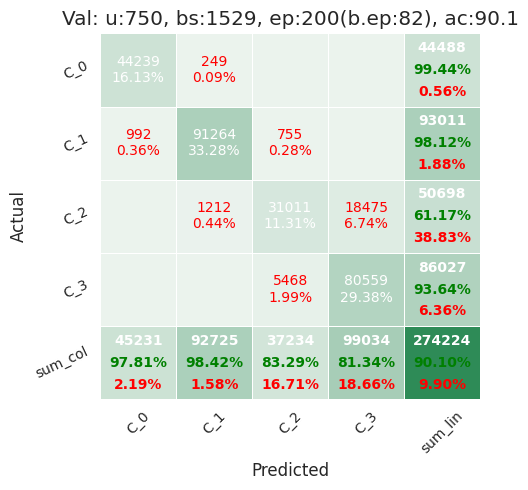

In [ ]:
expNo = 0   # Нужно указать параметры эксперимента для формирования заголовка
_H = res[expNo]
_ = plot_CM(model, x_val_src_Sq, np.argmax(y_val_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Val: u:{_H['units']}, bs:{_H['batch_size']}, ep:{_H['epochs']}(b.ep:{_H['best_epoch']}), ac:{_H['score']}", figsize=[5, 5])
#_ = plot_CM(model, x_val_src_Sq, np.argmax(y_val_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Validation", figsize=[5, 5])    # Без заголовка

2302/2302 [==============================] - 4s 2ms/step


<ipython-input-12-c7ddf3f22007>:51: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



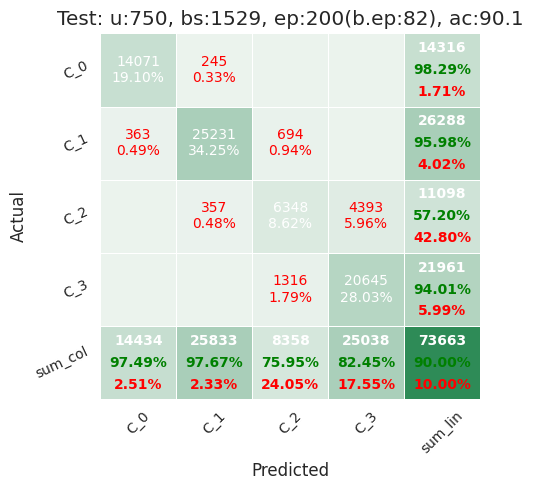

In [ ]:
expNo = 0   # Нужно указать параметры эксперимента для формирования заголовка
_H = res[expNo]
_ = plot_CM(model, x_test_src_Sq, np.argmax(y_test_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Test: u:{_H['units']}, bs:{_H['batch_size']}, ep:{_H['epochs']}(b.ep:{_H['best_epoch']}), ac:{_H['score']}", figsize=[5, 5])
#_ = plot_CM(model, x_test_src_Sq, np.argmax(y_val_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Test", figsize=[5, 5])    # Без заголовка

##### Эксперимент **без** группировки по клиентам

Загружаем понравившуюся модель (из сохранённых или из переменной `res`)

In [ ]:
# Эксп. № 0
model_path = '/content/drive/MyDrive/ML_Models/UnGrouped01/2023-09-12T14/training_chkpoint/Mdl_pr428659_vA99.516_vL0.0207_tA99.598_tL0.0179_e0125.keras'
# Эксп. № 3
model_path = '/content/drive/MyDrive/ML_Models/UnGrouped01/2023-09-12T14/training_chkpoint/Mdl_pr428659_vA99.746_vL0.0115_tA99.797_tL0.0096_e0148.keras'
model = tf.keras.models.load_model(model_path)

In [ ]:
# Пример содержимого объекта res:

res = [
  {
    'epochs': 125,
    'units': 615,
    'kernel_regularizer': None,
    'bias_initializer': "RandomUniform(-0.15, 1.15, seed=44)",
    'batch_size': 2297,
    'activation': 'elu',
    'best_epoch': 125,
    'score': 99.51,
    }
]


5542/5542 [==============================] - 10s 2ms/step


<ipython-input-10-c7ddf3f22007>:51: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



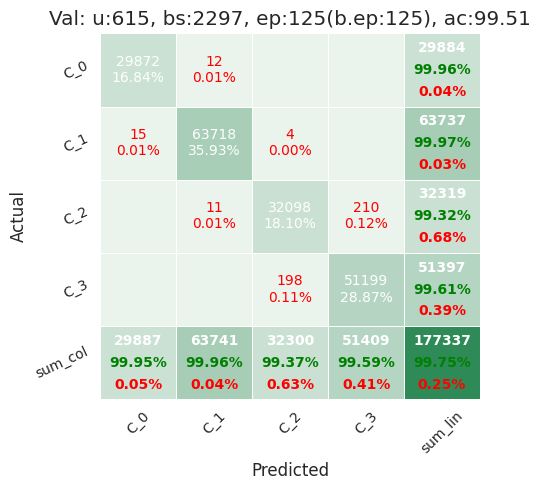

In [ ]:
expNo = 0   # Нужно указать параметры эксперимента для формирования заголовка
_H = res[expNo]
_ = plot_CM(model, x_val_src_Sq, np.argmax(y_val_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Val: u:{_H['units']}, bs:{_H['batch_size']}, ep:{_H['epochs']}(b.ep:{_H['best_epoch']}), ac:{_H['score']}", figsize=[5, 5])
#_ = plot_CM(model, x_val_src_Sq, np.argmax(y_val_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Validation", figsize=[5, 5])    # Без заголовка

5542/5542 [==============================] - 10s 2ms/step


<ipython-input-10-c7ddf3f22007>:51: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



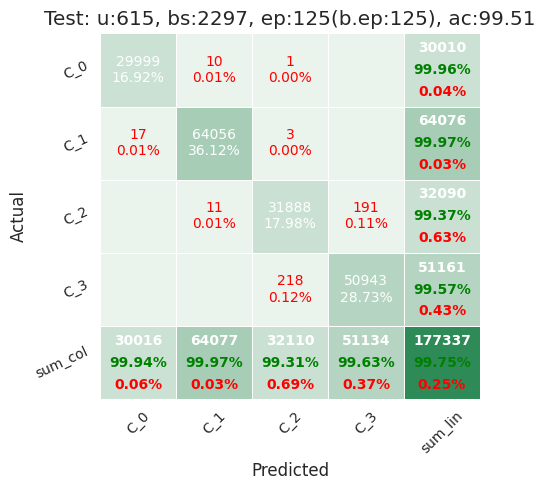

In [ ]:
expNo = 0   # Нужно указать параметры эксперимента для формирования заголовка
_H = res[expNo]
_ = plot_CM(model, x_test_src_Sq, np.argmax(y_test_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Test: u:{_H['units']}, bs:{_H['batch_size']}, ep:{_H['epochs']}(b.ep:{_H['best_epoch']}), ac:{_H['score']}", figsize=[5, 5])
#_ = plot_CM(model, x_test_src_Sq, np.argmax(y_val_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"Test", figsize=[5, 5])    # Без заголовка

## (Опционально) Ручной "тюнинг" модели

### Работа с моделью

In [ ]:
# Берем лучшие параметры из шага по перебору значений
#BEST_PRM = {'epochs': 1340, 'batch_size': 3548, 'units': 410, 'activation': 'sigmoid'}
#BEST_PRM = {'epochs': 250, 'batch_size': 42576, 'units': 122, 'activation': 'elu'}
#BEST_PRM = {'epochs': 1500, 'batch_size': 42576, 'units': 615, 'activation': 'elu'}
#BEST_PRM = {'epochs': 500, 'batch_size': 42576, 'units': 122, 'activation': 'elu'}
#BEST_PRM = {'epochs': 100, 'batch_size': 312, 'units': 122, 'activation': 'elu'}
#BEST_PRM = {'epochs': 500, 'batch_size': 42576, 'units': 923, 'activation': 'elu'}
#BEST_PRM = {'epochs': 125, 'batch_size': 85152, 'units': 410, 'activation': 'elu'}
#BEST_PRM = {'epochs': 1500, 'batch_size': 3548, 'units': 410, 'activation': 'sigmoid'}
BEST_PRM = {'epochs': 200, 'batch_size': 58474, 'units': 273, 'activation': 'elu'}

In [ ]:
# Выбираем рабочие датасеты
#X = x_train_src
X = x_train_src_Sq
Y = y_train_src
#Xv = x_val_src
Xv = x_val_src_Sq
Yv = y_val_src
r=0

### (Опционально) Загрузка существующей модели

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Models/Grouped01/2023-09-06T23/training_chkpoint/Mdl_pr96919_vA91.701_vL0.2074_tA92.763_tL0.1647_e0495.keras")
#model = tf.keras.models.load_model("/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Models/Grouped01/2023-09-07T16/training_chkpoint/Mdl_pr96919_vA91.679_vL0.2064_tA93.441_tL0.1527_e0659.keras")

### (Опционально) Воссоздаём модель

In [ ]:
# Воссоздаём модель вручную
r = 0
seed = 44
reset_and_fix_random_at(seed)
# Создаём простую модель
#model = Sequential(name='.'.join([f"{key}_{value}" for key, value in BEST_PRM.items()]))
model = Sequential()
# Создание callback-функции ModelCheckpoint для сохранения состояния лучшей эпохи в память
#checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', monitor='val_accuracy', mode='max', verbose=verbose, save_best_only=True, save_freq="epoch", save_weights_only=True)
# Создание полносвязного слоя с текущим количеством нейронов и активацией
# Layer #1
#model.add(Dropout(rate=0.25))
model.add(Dense(input_dim=X.shape[1], units=BEST_PRM['units'], activation=BEST_PRM['activation']))
#model.add(Dropout(rate=0.25))
# Layer #2
model.add(Dense(units=BEST_PRM['units'], activation=BEST_PRM['activation']))

# Создание полносвязного слоя с нейронами для каждого класса и softmax-активацией
model.add(Dense(Y.shape[1], activation='softmax'))
# Компиляция модели
#model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.00025), metrics=["accuracy", "AUC"])
RAP_P=0.9
M = ["accuracy", "AUC"]
RAP1 = tf.keras.metrics.RecallAtPrecision(precision=RAP_P, name=f'RAP_{RAP_P}')
RAP2 = tf.keras.metrics.RecallAtPrecision(precision=RAP_P, name=f'RAP_{RAP_P}')
#model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.00025), metrics=M + [RAP1])#, weighted_metrics=M + [RAP2])
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.000125), metrics=M)#, weighted_metrics=M + [RAP2])

In [ ]:
# Сохраняем начальную модель
model.save(f"/content/drive/MyDrive/ForColab/Stazh/1 Scoring/FromAnna/First_Best_lr00025_{BEST_PRM['units']}_empty.keras", overwrite=True, save_format='keras')

### (Опционально) (До)Обучаем модель

In [ ]:
r = 495

In [ ]:
!rm -d -r -f "/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Models/Grouped01/2023-09-07T16/"

In [ ]:
clb = get_callbacks("Grouped01", "/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Models", min_acc=0.917)

SaveBestModelCallback('directory=/content/drive/MyDrive/ForColab/Stazh/1 Scoring/Models/Grouped01/2023-09-07T17/training_chkpoint', monitor='val_accuracy', mode='max', min_delta=0.0002, min_acc=0.917) created!


In [ ]:
# обучаем модель и добавляем результаты обучения в конечный ответ
seed = 44
reset_and_fix_random_at(seed)
res = model.fit(
    x=X,
    y=Y,
    batch_size=BEST_PRM['batch_size'],
    epochs=BEST_PRM['epochs'] + r,
    #class_weight=class_weights,
    validation_data=(Xv, Yv),
    callbacks=clb,
    verbose=2,
    initial_epoch=r,
    #shuffle=False
)
r = r + BEST_PRM['epochs']

Epoch 801/1000
Epoch#800: Accuracies: train=0.9367602467536926[True], validation=0.914007842540741[False], best=0.917
25/25 - 1s - loss: 0.1489 - accuracy: 0.9368 - auc: 0.9955 - val_loss: 0.2070 - val_accuracy: 0.9140 - val_auc: 0.9905 - 1s/epoch - 43ms/step
Epoch 802/1000
Epoch#801: Accuracies: train=0.9368792772293091[True], validation=0.9134876132011414[False], best=0.917
25/25 - 1s - loss: 0.1488 - accuracy: 0.9369 - auc: 0.9955 - val_loss: 0.2074 - val_accuracy: 0.9135 - val_auc: 0.9905 - 684ms/epoch - 27ms/step
Epoch 803/1000
Epoch#802: Accuracies: train=0.9368382692337036[True], validation=0.9141497015953064[False], best=0.917
25/25 - 1s - loss: 0.1488 - accuracy: 0.9368 - auc: 0.9955 - val_loss: 0.2071 - val_accuracy: 0.9141 - val_auc: 0.9905 - 685ms/epoch - 27ms/step
Epoch 804/1000
Epoch#803: Accuracies: train=0.9368197917938232[True], validation=0.9152610301971436[False], best=0.917
25/25 - 1s - loss: 0.1488 - accuracy: 0.9368 - auc: 0.9955 - val_loss: 0.2070 - val_accuracy:

#### Меняем скорость (до)обучения

In [ ]:
print("Текущее значение learning rate:", model.optimizer.lr)

Текущее значение learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0001875>


In [ ]:
model.optimizer.learning_rate.assign(model.optimizer.lr * 0.35)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2.2968748e-05>

#### Визуализация результатов обучения

In [ ]:
history_df = pd.DataFrame(res.history)
fig = px.line(history_df, x=history_df.index, y=history_df.columns, title=_H['activation'])
fig.show()

3965/3965 [==============================] - 7s 2ms/step


<ipython-input-12-c7ddf3f22007>:51: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



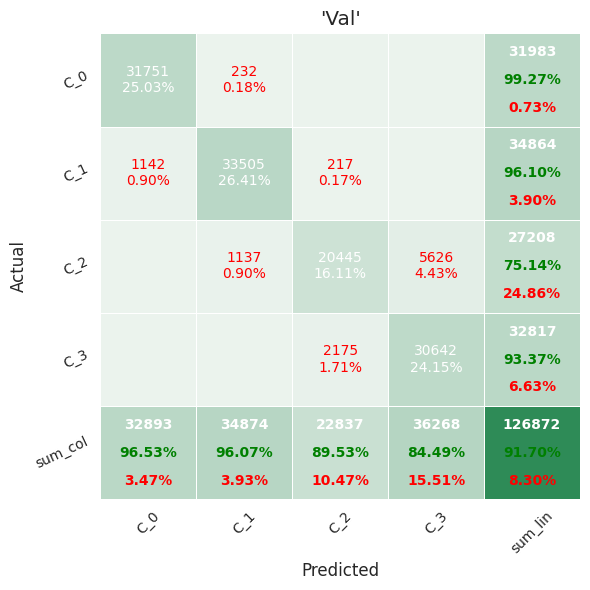

In [ ]:
#_ = Yv
#_ = np.argmax(_.reshape((_.shape[0], 2, _.shape[1]), order='C'), axis=2)[:,0]
_ = plot_CM(model, x_val_src_Sq, np.argmax(Yv, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"'Val'", figsize=[6, 6])

3730/3730 [==============================] - 5s 1ms/step


<ipython-input-12-c7ddf3f22007>:51: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



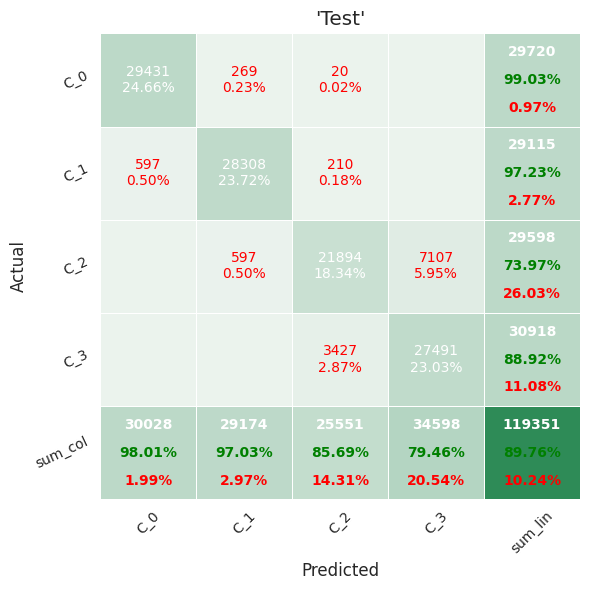

In [ ]:
#_ = Yv
#_ = np.argmax(_.reshape((_.shape[0], 2, _.shape[1]), order='C'), axis=2)[:,0]
_ = plot_CM(model, x_test_src_Sq, np.argmax(y_test_src, axis=1), ['C_0', 'C_1', 'C_2', 'C_3'], f"'Test'", figsize=[6, 6])